# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 48kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

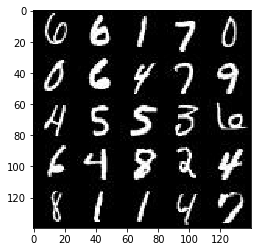

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

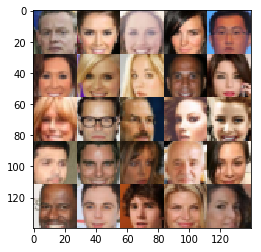

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28x3 (faces) or 28x28x1 (mnist)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        # last layer is fully connected
        x4 = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        # start with a fully connected layer
        x1 = tf.layers.dense(z, 4*4*1024)
        
        # reshape it for a convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x1024 now
        
        # first convolutional layer
        # formula for converting 4x4 input to 7x7 output: 
        #      https://discussions.udacity.com/t/project5-discriminator-and-genarator-layers/249101/9
        conv1 = tf.layers.conv2d_transpose(x1, 512, 4, strides=1, padding='valid')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        # now 7x7x512
        
        # second convolutional layer
        x2 = tf.layers.conv2d_transpose(conv1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        # final convolutional layer. 
        # Don't use batch normalization.
        # Use a tanh activation function
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        # 28x28xOut_channel_dim now
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # get the discriminator and generator variables
    train_vars = tf.trainable_variables()
    d_vars = [v for v in train_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in train_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_losses(d_loss, g_loss):
    """
    Plot the discriminator and generator losses on the same graph
    :param d_loss: list of loss values for the discriminator
    :param g_loss: list of loss values for the generator
    """
    fig, ax = plt.subplots()
    plt.plot(d_loss, label='Discriminator', alpha=0.5)
    plt.plot(g_loss, label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()    

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    import time 
    real_inputs, z_inputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_no = 0
    show_every = 100
    stats_every = 5
    n_images_to_show = 25
    n_images = data_shape[0]
    total_batches = (n_images // batch_size) * epoch_count
    start_time = time.time() 
    d_losses = []
    g_losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # batch_start = time.time()
                batch_no += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                
                # compute some execution time stats for each batch
                if batch_no % stats_every == 0: 
                    current_time = time.time()
                    total_time = current_time - start_time
                    # time_this_batch = current_time - batch_start
                    time_per_batch = total_time / batch_no
                    remaining_time = int(time_per_batch * (total_batches - batch_no))

                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({z_inputs: batch_z, lr: learning_rate})
                    d_losses.append(train_loss_d)
                    g_losses.append(train_loss_g)
                    print("Epoch {}/{}: batch {}/{}: \ttime/batch: {:.2f}s\tremaining time: {}s".format(
                         epoch_i+1, epoch_count, batch_no, total_batches, time_per_batch, remaining_time),
                         "\td_loss: {:.4f}\tg_loss: {:.4f}".format(train_loss_d, train_loss_g))
                
                # show generator output every show_every steps
                if batch_no % show_every == 0: 
                    show_generator_output(sess, n_images_to_show, z_inputs, data_shape[-1], data_image_mode)

        # show the final output
        show_generator_output(sess, n_images_to_show, z_inputs, data_shape[-1], data_image_mode)
        return d_losses, g_losses


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2: batch 5/936: 	time/batch: 1.20s	remaining time: 1114s 	d_loss: 1.6346	g_loss: 0.3756
Epoch 1/2: batch 10/936: 	time/batch: 0.76s	remaining time: 703s 	d_loss: 0.4045	g_loss: 3.0143
Epoch 1/2: batch 15/936: 	time/batch: 0.61s	remaining time: 563s 	d_loss: 0.3257	g_loss: 5.2864
Epoch 1/2: batch 20/936: 	time/batch: 0.54s	remaining time: 492s 	d_loss: 0.1611	g_loss: 2.3364
Epoch 1/2: batch 25/936: 	time/batch: 0.49s	remaining time: 449s 	d_loss: 0.6097	g_loss: 1.0379
Epoch 1/2: batch 30/936: 	time/batch: 0.46s	remaining time: 419s 	d_loss: 0.4782	g_loss: 1.1709
Epoch 1/2: batch 35/936: 	time/batch: 0.44s	remaining time: 398s 	d_loss: 0.3628	g_loss: 1.5947
Epoch 1/2: batch 40/936: 	time/batch: 0.43s	remaining time: 381s 	d_loss: 0.2077	g_loss: 2.6736
Epoch 1/2: batch 45/936: 	time/batch: 0.41s	remaining time: 368s 	d_loss: 0.2303	g_loss: 2.1087
Epoch 1/2: batch 50/936: 	time/batch: 0.40s	remaining time: 357s 	d_loss: 0.3916	g_loss: 1.3622
Epoch 1/2: batch 55/936: 	time/batch: 0.

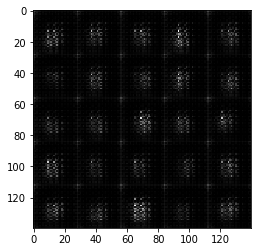

Epoch 1/2: batch 105/936: 	time/batch: 0.36s	remaining time: 301s 	d_loss: 0.2386	g_loss: 7.0864
Epoch 1/2: batch 110/936: 	time/batch: 0.36s	remaining time: 297s 	d_loss: 0.5208	g_loss: 2.2154
Epoch 1/2: batch 115/936: 	time/batch: 0.36s	remaining time: 293s 	d_loss: 0.1540	g_loss: 2.5608
Epoch 1/2: batch 120/936: 	time/batch: 0.36s	remaining time: 290s 	d_loss: 0.1313	g_loss: 3.2642
Epoch 1/2: batch 125/936: 	time/batch: 0.35s	remaining time: 287s 	d_loss: 0.0817	g_loss: 3.2201
Epoch 1/2: batch 130/936: 	time/batch: 0.35s	remaining time: 284s 	d_loss: 0.1917	g_loss: 2.4972
Epoch 1/2: batch 135/936: 	time/batch: 0.35s	remaining time: 281s 	d_loss: 0.1228	g_loss: 3.1931
Epoch 1/2: batch 140/936: 	time/batch: 0.35s	remaining time: 278s 	d_loss: 0.0851	g_loss: 3.3088
Epoch 1/2: batch 145/936: 	time/batch: 0.35s	remaining time: 275s 	d_loss: 0.1031	g_loss: 3.4159
Epoch 1/2: batch 150/936: 	time/batch: 0.35s	remaining time: 273s 	d_loss: 0.1560	g_loss: 2.8439
Epoch 1/2: batch 155/936: 	tim

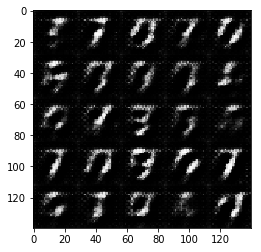

Epoch 1/2: batch 205/936: 	time/batch: 0.34s	remaining time: 249s 	d_loss: 0.0800	g_loss: 3.3500
Epoch 1/2: batch 210/936: 	time/batch: 0.34s	remaining time: 246s 	d_loss: 0.1464	g_loss: 3.0615
Epoch 1/2: batch 215/936: 	time/batch: 0.34s	remaining time: 244s 	d_loss: 0.2608	g_loss: 2.0459
Epoch 1/2: batch 220/936: 	time/batch: 0.34s	remaining time: 242s 	d_loss: 0.1148	g_loss: 2.8209
Epoch 1/2: batch 225/936: 	time/batch: 0.34s	remaining time: 240s 	d_loss: 0.1589	g_loss: 3.1887
Epoch 1/2: batch 230/936: 	time/batch: 0.34s	remaining time: 238s 	d_loss: 0.0990	g_loss: 3.8209
Epoch 1/2: batch 235/936: 	time/batch: 0.34s	remaining time: 236s 	d_loss: 0.1206	g_loss: 2.7797
Epoch 1/2: batch 240/936: 	time/batch: 0.34s	remaining time: 234s 	d_loss: 0.0862	g_loss: 3.7321
Epoch 1/2: batch 245/936: 	time/batch: 0.34s	remaining time: 232s 	d_loss: 0.0993	g_loss: 3.1471
Epoch 1/2: batch 250/936: 	time/batch: 0.34s	remaining time: 230s 	d_loss: 0.0842	g_loss: 3.2516
Epoch 1/2: batch 255/936: 	tim

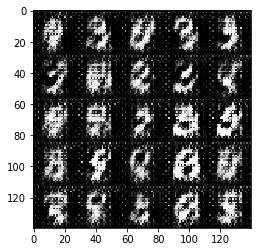

Epoch 1/2: batch 305/936: 	time/batch: 0.33s	remaining time: 210s 	d_loss: 0.0493	g_loss: 3.7661
Epoch 1/2: batch 310/936: 	time/batch: 0.33s	remaining time: 208s 	d_loss: 0.0514	g_loss: 3.6453
Epoch 1/2: batch 315/936: 	time/batch: 0.33s	remaining time: 206s 	d_loss: 0.0774	g_loss: 3.4369
Epoch 1/2: batch 320/936: 	time/batch: 0.33s	remaining time: 204s 	d_loss: 0.0617	g_loss: 3.5176
Epoch 1/2: batch 325/936: 	time/batch: 0.33s	remaining time: 203s 	d_loss: 0.0804	g_loss: 3.2265
Epoch 1/2: batch 330/936: 	time/batch: 0.33s	remaining time: 201s 	d_loss: 0.0708	g_loss: 3.2720
Epoch 1/2: batch 335/936: 	time/batch: 0.33s	remaining time: 199s 	d_loss: 0.0393	g_loss: 4.5695
Epoch 1/2: batch 340/936: 	time/batch: 0.33s	remaining time: 197s 	d_loss: 0.1559	g_loss: 8.8279
Epoch 1/2: batch 345/936: 	time/batch: 0.33s	remaining time: 196s 	d_loss: 0.0102	g_loss: 8.5795
Epoch 1/2: batch 350/936: 	time/batch: 0.33s	remaining time: 194s 	d_loss: 3.7581	g_loss: 0.0341
Epoch 1/2: batch 355/936: 	tim

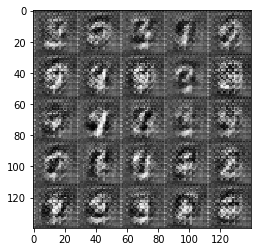

Epoch 1/2: batch 405/936: 	time/batch: 0.33s	remaining time: 175s 	d_loss: 0.7008	g_loss: 1.6523
Epoch 1/2: batch 410/936: 	time/batch: 0.33s	remaining time: 173s 	d_loss: 0.5252	g_loss: 2.7837
Epoch 1/2: batch 415/936: 	time/batch: 0.33s	remaining time: 171s 	d_loss: 0.5724	g_loss: 1.5989
Epoch 1/2: batch 420/936: 	time/batch: 0.33s	remaining time: 170s 	d_loss: 1.4781	g_loss: 0.4095
Epoch 1/2: batch 425/936: 	time/batch: 0.33s	remaining time: 168s 	d_loss: 0.2419	g_loss: 2.8179
Epoch 1/2: batch 430/936: 	time/batch: 0.33s	remaining time: 166s 	d_loss: 0.5882	g_loss: 1.7199
Epoch 1/2: batch 435/936: 	time/batch: 0.33s	remaining time: 164s 	d_loss: 0.4340	g_loss: 2.6446
Epoch 1/2: batch 440/936: 	time/batch: 0.33s	remaining time: 163s 	d_loss: 0.4445	g_loss: 1.5849
Epoch 1/2: batch 445/936: 	time/batch: 0.33s	remaining time: 161s 	d_loss: 0.3779	g_loss: 1.7527
Epoch 1/2: batch 450/936: 	time/batch: 0.33s	remaining time: 159s 	d_loss: 0.7409	g_loss: 0.8403
Epoch 1/2: batch 455/936: 	tim

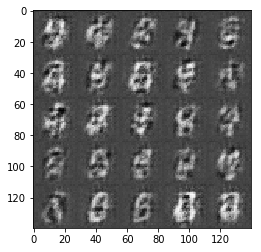

Epoch 2/2: batch 505/936: 	time/batch: 0.32s	remaining time: 138s 	d_loss: 0.2429	g_loss: 2.5024
Epoch 2/2: batch 510/936: 	time/batch: 0.32s	remaining time: 136s 	d_loss: 0.3667	g_loss: 1.6649
Epoch 2/2: batch 515/936: 	time/batch: 0.32s	remaining time: 134s 	d_loss: 0.2217	g_loss: 2.5955
Epoch 2/2: batch 520/936: 	time/batch: 0.32s	remaining time: 132s 	d_loss: 1.0030	g_loss: 0.5637
Epoch 2/2: batch 525/936: 	time/batch: 0.32s	remaining time: 130s 	d_loss: 0.4086	g_loss: 1.4535
Epoch 2/2: batch 530/936: 	time/batch: 0.32s	remaining time: 128s 	d_loss: 0.2799	g_loss: 2.8098
Epoch 2/2: batch 535/936: 	time/batch: 0.32s	remaining time: 126s 	d_loss: 0.2863	g_loss: 1.9306
Epoch 2/2: batch 540/936: 	time/batch: 0.32s	remaining time: 124s 	d_loss: 0.3453	g_loss: 1.6427
Epoch 2/2: batch 545/936: 	time/batch: 0.31s	remaining time: 123s 	d_loss: 0.2607	g_loss: 2.1990
Epoch 2/2: batch 550/936: 	time/batch: 0.31s	remaining time: 121s 	d_loss: 0.2376	g_loss: 2.6917
Epoch 2/2: batch 555/936: 	tim

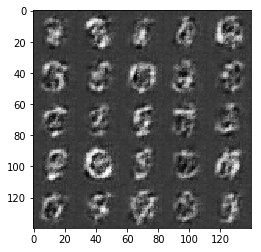

Epoch 2/2: batch 605/936: 	time/batch: 0.31s	remaining time: 101s 	d_loss: 0.2884	g_loss: 2.0447
Epoch 2/2: batch 610/936: 	time/batch: 0.31s	remaining time: 99s 	d_loss: 0.2837	g_loss: 2.2121
Epoch 2/2: batch 615/936: 	time/batch: 0.31s	remaining time: 98s 	d_loss: 0.2424	g_loss: 2.1962
Epoch 2/2: batch 620/936: 	time/batch: 0.30s	remaining time: 96s 	d_loss: 0.2183	g_loss: 2.4618
Epoch 2/2: batch 625/936: 	time/batch: 0.30s	remaining time: 94s 	d_loss: 0.3441	g_loss: 1.6188
Epoch 2/2: batch 630/936: 	time/batch: 0.30s	remaining time: 92s 	d_loss: 0.2249	g_loss: 2.1071
Epoch 2/2: batch 635/936: 	time/batch: 0.30s	remaining time: 91s 	d_loss: 1.4543	g_loss: 0.3387
Epoch 2/2: batch 640/936: 	time/batch: 0.30s	remaining time: 89s 	d_loss: 0.5648	g_loss: 1.1263
Epoch 2/2: batch 645/936: 	time/batch: 0.30s	remaining time: 87s 	d_loss: 0.2955	g_loss: 2.4394
Epoch 2/2: batch 650/936: 	time/batch: 0.30s	remaining time: 86s 	d_loss: 0.2275	g_loss: 2.2267
Epoch 2/2: batch 655/936: 	time/batch: 

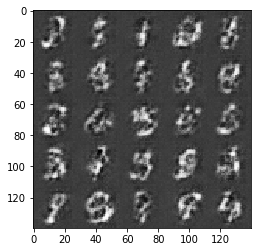

Epoch 2/2: batch 705/936: 	time/batch: 0.30s	remaining time: 68s 	d_loss: 0.2740	g_loss: 1.9530
Epoch 2/2: batch 710/936: 	time/batch: 0.30s	remaining time: 66s 	d_loss: 0.2428	g_loss: 2.1672
Epoch 2/2: batch 715/936: 	time/batch: 0.29s	remaining time: 65s 	d_loss: 0.1886	g_loss: 2.3704
Epoch 2/2: batch 720/936: 	time/batch: 0.29s	remaining time: 63s 	d_loss: 0.1683	g_loss: 3.0243
Epoch 2/2: batch 725/936: 	time/batch: 0.29s	remaining time: 62s 	d_loss: 0.1832	g_loss: 2.5400
Epoch 2/2: batch 730/936: 	time/batch: 0.29s	remaining time: 60s 	d_loss: 0.1269	g_loss: 3.3865
Epoch 2/2: batch 735/936: 	time/batch: 0.29s	remaining time: 58s 	d_loss: 0.1081	g_loss: 3.1511
Epoch 2/2: batch 740/936: 	time/batch: 0.29s	remaining time: 57s 	d_loss: 0.1791	g_loss: 2.4869
Epoch 2/2: batch 745/936: 	time/batch: 0.29s	remaining time: 55s 	d_loss: 0.1754	g_loss: 2.4203
Epoch 2/2: batch 750/936: 	time/batch: 0.29s	remaining time: 54s 	d_loss: 0.1454	g_loss: 3.1177
Epoch 2/2: batch 755/936: 	time/batch: 0

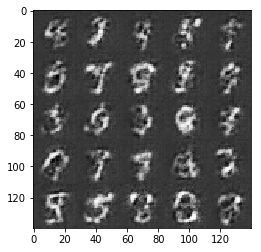

Epoch 2/2: batch 805/936: 	time/batch: 0.29s	remaining time: 37s 	d_loss: 0.2624	g_loss: 1.8717
Epoch 2/2: batch 810/936: 	time/batch: 0.29s	remaining time: 36s 	d_loss: 0.1523	g_loss: 2.8248
Epoch 2/2: batch 815/936: 	time/batch: 0.29s	remaining time: 34s 	d_loss: 0.1478	g_loss: 2.5732
Epoch 2/2: batch 820/936: 	time/batch: 0.29s	remaining time: 33s 	d_loss: 0.1639	g_loss: 2.7608
Epoch 2/2: batch 825/936: 	time/batch: 0.29s	remaining time: 31s 	d_loss: 0.1234	g_loss: 2.8421
Epoch 2/2: batch 830/936: 	time/batch: 0.29s	remaining time: 30s 	d_loss: 0.1303	g_loss: 2.8231
Epoch 2/2: batch 835/936: 	time/batch: 0.29s	remaining time: 28s 	d_loss: 0.1161	g_loss: 2.9541
Epoch 2/2: batch 840/936: 	time/batch: 0.29s	remaining time: 27s 	d_loss: 0.1459	g_loss: 2.4601
Epoch 2/2: batch 845/936: 	time/batch: 0.28s	remaining time: 25s 	d_loss: 0.0903	g_loss: 3.4298
Epoch 2/2: batch 850/936: 	time/batch: 0.28s	remaining time: 24s 	d_loss: 0.1526	g_loss: 2.5977
Epoch 2/2: batch 855/936: 	time/batch: 0

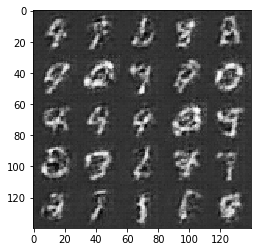

Epoch 2/2: batch 905/936: 	time/batch: 0.28s	remaining time: 8s 	d_loss: 0.0816	g_loss: 3.5752
Epoch 2/2: batch 910/936: 	time/batch: 0.28s	remaining time: 7s 	d_loss: 0.1109	g_loss: 2.8015
Epoch 2/2: batch 915/936: 	time/batch: 0.28s	remaining time: 5s 	d_loss: 1.1372	g_loss: 7.0047
Epoch 2/2: batch 920/936: 	time/batch: 0.28s	remaining time: 4s 	d_loss: 0.4214	g_loss: 2.4919
Epoch 2/2: batch 925/936: 	time/batch: 0.28s	remaining time: 3s 	d_loss: 2.1395	g_loss: 0.2414
Epoch 2/2: batch 930/936: 	time/batch: 0.28s	remaining time: 1s 	d_loss: 0.3936	g_loss: 1.6367
Epoch 2/2: batch 935/936: 	time/batch: 0.28s	remaining time: 0s 	d_loss: 0.2975	g_loss: 1.9814


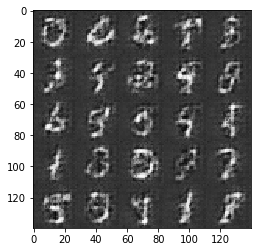

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

d_losses = []
g_losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    # jcc: added lists for plotting discriminator and generator losses
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### First run
Hyperparameters:
- batch_size = 128
- z_dim = 100
- learning_rate = 0.0002
- beta1 = 0.5
- alpha = 0.2

Generator:
- layer 1: 4x4x512 with LRELU
- layer 2: 7x7x256 with LRELU
- layer 3: 14x14x128 with LRELU
- layer 4: 28x28xOutput_Channel with TANH

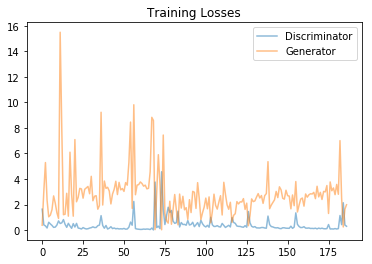

In [15]:
plot_losses(d_losses, g_losses)

### MNIST no. 2
Same hyperparameters as the first run, but we've made the generator CNN a little deeper

Hyperparameters:
- batch_size = 128
- z_dim = 100
- learning_rate = 0.0002
- beta1 = 0.5
- alpha = 0.2

Generator:
- layer 1: 4x4x1024 with LRELU activation
- layer 2: 7x7x512 with LRELU
- layer 3: 14x14x256 with LRELU
- layer 4: 28x28xOutput_Channel with TANH

Epoch 1/2: batch 5/936: 	time/batch: 0.90s	remaining time: 835s 	d_loss: 0.8617	g_loss: 0.9680
Epoch 1/2: batch 10/936: 	time/batch: 0.68s	remaining time: 632s 	d_loss: 0.2170	g_loss: 1.7984
Epoch 1/2: batch 15/936: 	time/batch: 0.61s	remaining time: 561s 	d_loss: 0.0875	g_loss: 4.0416
Epoch 1/2: batch 20/936: 	time/batch: 0.57s	remaining time: 524s 	d_loss: 0.0859	g_loss: 2.9897
Epoch 1/2: batch 25/936: 	time/batch: 0.55s	remaining time: 501s 	d_loss: 0.0635	g_loss: 3.1180
Epoch 1/2: batch 30/936: 	time/batch: 0.54s	remaining time: 486s 	d_loss: 0.0592	g_loss: 3.1410
Epoch 1/2: batch 35/936: 	time/batch: 0.53s	remaining time: 473s 	d_loss: 0.0441	g_loss: 4.6360
Epoch 1/2: batch 40/936: 	time/batch: 0.52s	remaining time: 464s 	d_loss: 0.1200	g_loss: 2.3621
Epoch 1/2: batch 45/936: 	time/batch: 0.51s	remaining time: 456s 	d_loss: 0.1011	g_loss: 3.3264
Epoch 1/2: batch 50/936: 	time/batch: 0.51s	remaining time: 449s 	d_loss: 0.7591	g_loss: 13.5862
Epoch 1/2: batch 55/936: 	time/batch: 0.

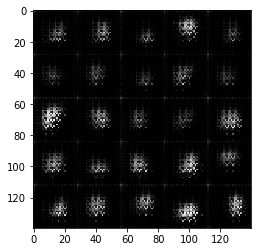

Epoch 1/2: batch 105/936: 	time/batch: 0.49s	remaining time: 407s 	d_loss: 0.6588	g_loss: 1.4160
Epoch 1/2: batch 110/936: 	time/batch: 0.49s	remaining time: 404s 	d_loss: 0.4081	g_loss: 2.4852
Epoch 1/2: batch 115/936: 	time/batch: 0.49s	remaining time: 401s 	d_loss: 0.1662	g_loss: 3.4386
Epoch 1/2: batch 120/936: 	time/batch: 0.49s	remaining time: 397s 	d_loss: 0.5682	g_loss: 1.8193
Epoch 1/2: batch 125/936: 	time/batch: 0.49s	remaining time: 394s 	d_loss: 0.2686	g_loss: 2.4812
Epoch 1/2: batch 130/936: 	time/batch: 0.49s	remaining time: 391s 	d_loss: 0.3420	g_loss: 1.9045
Epoch 1/2: batch 135/936: 	time/batch: 0.49s	remaining time: 388s 	d_loss: 0.1907	g_loss: 2.5541
Epoch 1/2: batch 140/936: 	time/batch: 0.48s	remaining time: 385s 	d_loss: 0.3129	g_loss: 4.3448
Epoch 1/2: batch 145/936: 	time/batch: 0.48s	remaining time: 382s 	d_loss: 0.1798	g_loss: 2.8747
Epoch 1/2: batch 150/936: 	time/batch: 0.48s	remaining time: 379s 	d_loss: 0.1302	g_loss: 3.0457
Epoch 1/2: batch 155/936: 	tim

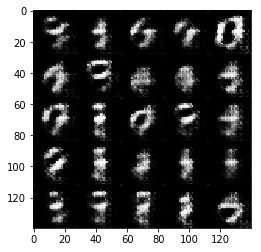

Epoch 1/2: batch 205/936: 	time/batch: 0.48s	remaining time: 351s 	d_loss: 0.2351	g_loss: 2.5176
Epoch 1/2: batch 210/936: 	time/batch: 0.48s	remaining time: 348s 	d_loss: 0.9106	g_loss: 7.0209
Epoch 1/2: batch 215/936: 	time/batch: 0.48s	remaining time: 345s 	d_loss: 0.2218	g_loss: 2.2134
Epoch 1/2: batch 220/936: 	time/batch: 0.48s	remaining time: 343s 	d_loss: 0.1487	g_loss: 2.6421
Epoch 1/2: batch 225/936: 	time/batch: 0.48s	remaining time: 340s 	d_loss: 0.1448	g_loss: 3.1249
Epoch 1/2: batch 230/936: 	time/batch: 0.48s	remaining time: 338s 	d_loss: 0.0760	g_loss: 3.3835
Epoch 1/2: batch 235/936: 	time/batch: 0.48s	remaining time: 335s 	d_loss: 0.0909	g_loss: 3.1523
Epoch 1/2: batch 240/936: 	time/batch: 0.48s	remaining time: 332s 	d_loss: 0.0890	g_loss: 3.2569
Epoch 1/2: batch 245/936: 	time/batch: 0.48s	remaining time: 330s 	d_loss: 0.0632	g_loss: 3.6658
Epoch 1/2: batch 250/936: 	time/batch: 0.48s	remaining time: 327s 	d_loss: 0.0947	g_loss: 3.1613
Epoch 1/2: batch 255/936: 	tim

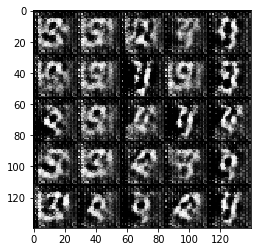

Epoch 1/2: batch 305/936: 	time/batch: 0.48s	remaining time: 300s 	d_loss: 0.0329	g_loss: 4.6295
Epoch 1/2: batch 310/936: 	time/batch: 0.48s	remaining time: 298s 	d_loss: 0.0520	g_loss: 4.0032
Epoch 1/2: batch 315/936: 	time/batch: 0.48s	remaining time: 295s 	d_loss: 0.0372	g_loss: 4.3413
Epoch 1/2: batch 320/936: 	time/batch: 0.48s	remaining time: 293s 	d_loss: 0.0492	g_loss: 4.6335
Epoch 1/2: batch 325/936: 	time/batch: 0.48s	remaining time: 290s 	d_loss: 8.1099	g_loss: 18.2938
Epoch 1/2: batch 330/936: 	time/batch: 0.48s	remaining time: 288s 	d_loss: 5.4984	g_loss: 12.5627
Epoch 1/2: batch 335/936: 	time/batch: 0.48s	remaining time: 285s 	d_loss: 1.0811	g_loss: 0.6546
Epoch 1/2: batch 340/936: 	time/batch: 0.48s	remaining time: 283s 	d_loss: 0.1277	g_loss: 3.2792
Epoch 1/2: batch 345/936: 	time/batch: 0.48s	remaining time: 281s 	d_loss: 0.1503	g_loss: 2.8095
Epoch 1/2: batch 350/936: 	time/batch: 0.48s	remaining time: 278s 	d_loss: 0.2058	g_loss: 3.1875
Epoch 1/2: batch 355/936: 	t

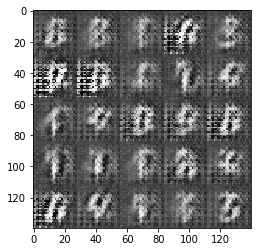

Epoch 1/2: batch 405/936: 	time/batch: 0.48s	remaining time: 252s 	d_loss: 0.0698	g_loss: 5.0383
Epoch 1/2: batch 410/936: 	time/batch: 0.47s	remaining time: 249s 	d_loss: 0.5040	g_loss: 1.9748
Epoch 1/2: batch 415/936: 	time/batch: 0.47s	remaining time: 247s 	d_loss: 0.2294	g_loss: 3.0556
Epoch 1/2: batch 420/936: 	time/batch: 0.47s	remaining time: 244s 	d_loss: 0.1042	g_loss: 4.0413
Epoch 1/2: batch 425/936: 	time/batch: 0.47s	remaining time: 242s 	d_loss: 0.1712	g_loss: 2.7327
Epoch 1/2: batch 430/936: 	time/batch: 0.47s	remaining time: 240s 	d_loss: 1.1655	g_loss: 0.6889
Epoch 1/2: batch 435/936: 	time/batch: 0.47s	remaining time: 237s 	d_loss: 0.4910	g_loss: 2.0986
Epoch 1/2: batch 440/936: 	time/batch: 0.47s	remaining time: 235s 	d_loss: 1.8396	g_loss: 0.3434
Epoch 1/2: batch 445/936: 	time/batch: 0.47s	remaining time: 232s 	d_loss: 0.1787	g_loss: 2.9398
Epoch 1/2: batch 450/936: 	time/batch: 0.47s	remaining time: 230s 	d_loss: 0.3361	g_loss: 2.2188
Epoch 1/2: batch 455/936: 	tim

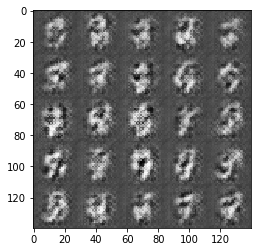

Epoch 2/2: batch 505/936: 	time/batch: 0.47s	remaining time: 204s 	d_loss: 0.1699	g_loss: 2.5982
Epoch 2/2: batch 510/936: 	time/batch: 0.47s	remaining time: 201s 	d_loss: 0.6269	g_loss: 3.7552
Epoch 2/2: batch 515/936: 	time/batch: 0.47s	remaining time: 199s 	d_loss: 0.1905	g_loss: 2.3267
Epoch 2/2: batch 520/936: 	time/batch: 0.47s	remaining time: 197s 	d_loss: 0.1128	g_loss: 5.2098
Epoch 2/2: batch 525/936: 	time/batch: 0.47s	remaining time: 194s 	d_loss: 0.7107	g_loss: 0.8342
Epoch 2/2: batch 530/936: 	time/batch: 0.47s	remaining time: 192s 	d_loss: 0.2285	g_loss: 2.6809
Epoch 2/2: batch 535/936: 	time/batch: 0.47s	remaining time: 189s 	d_loss: 0.0820	g_loss: 5.2786
Epoch 2/2: batch 540/936: 	time/batch: 0.47s	remaining time: 187s 	d_loss: 0.1168	g_loss: 4.1852
Epoch 2/2: batch 545/936: 	time/batch: 0.47s	remaining time: 185s 	d_loss: 0.4068	g_loss: 1.3762
Epoch 2/2: batch 550/936: 	time/batch: 0.47s	remaining time: 182s 	d_loss: 0.2204	g_loss: 3.1511
Epoch 2/2: batch 555/936: 	tim

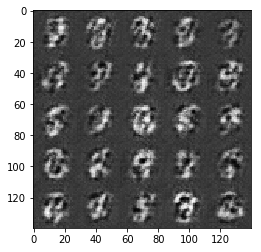

Epoch 2/2: batch 605/936: 	time/batch: 0.47s	remaining time: 156s 	d_loss: 0.2508	g_loss: 2.0457
Epoch 2/2: batch 610/936: 	time/batch: 0.47s	remaining time: 154s 	d_loss: 0.3560	g_loss: 1.6111
Epoch 2/2: batch 615/936: 	time/batch: 0.47s	remaining time: 151s 	d_loss: 0.2453	g_loss: 1.9795
Epoch 2/2: batch 620/936: 	time/batch: 0.47s	remaining time: 149s 	d_loss: 0.1038	g_loss: 3.7912
Epoch 2/2: batch 625/936: 	time/batch: 0.47s	remaining time: 147s 	d_loss: 0.1202	g_loss: 3.0979
Epoch 2/2: batch 630/936: 	time/batch: 0.47s	remaining time: 144s 	d_loss: 0.3379	g_loss: 1.6818
Epoch 2/2: batch 635/936: 	time/batch: 0.47s	remaining time: 142s 	d_loss: 0.1175	g_loss: 3.4526
Epoch 2/2: batch 640/936: 	time/batch: 0.47s	remaining time: 139s 	d_loss: 0.2178	g_loss: 2.2883
Epoch 2/2: batch 645/936: 	time/batch: 0.47s	remaining time: 137s 	d_loss: 0.2784	g_loss: 1.8560
Epoch 2/2: batch 650/936: 	time/batch: 0.47s	remaining time: 135s 	d_loss: 0.1613	g_loss: 2.9457
Epoch 2/2: batch 655/936: 	tim

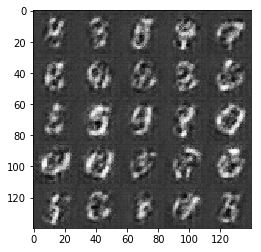

Epoch 2/2: batch 705/936: 	time/batch: 0.47s	remaining time: 109s 	d_loss: 0.1646	g_loss: 3.3595
Epoch 2/2: batch 710/936: 	time/batch: 0.47s	remaining time: 106s 	d_loss: 0.0732	g_loss: 4.1389
Epoch 2/2: batch 715/936: 	time/batch: 0.47s	remaining time: 104s 	d_loss: 0.0993	g_loss: 2.9852
Epoch 2/2: batch 720/936: 	time/batch: 0.47s	remaining time: 102s 	d_loss: 0.0574	g_loss: 3.6607
Epoch 2/2: batch 725/936: 	time/batch: 0.47s	remaining time: 99s 	d_loss: 0.1012	g_loss: 2.8154
Epoch 2/2: batch 730/936: 	time/batch: 0.47s	remaining time: 97s 	d_loss: 0.0572	g_loss: 3.9376
Epoch 2/2: batch 735/936: 	time/batch: 0.47s	remaining time: 94s 	d_loss: 0.0899	g_loss: 4.3571
Epoch 2/2: batch 740/936: 	time/batch: 0.47s	remaining time: 92s 	d_loss: 0.0538	g_loss: 4.0318
Epoch 2/2: batch 745/936: 	time/batch: 0.47s	remaining time: 90s 	d_loss: 0.0405	g_loss: 4.1478
Epoch 2/2: batch 750/936: 	time/batch: 0.47s	remaining time: 87s 	d_loss: 3.7527	g_loss: 10.0027
Epoch 2/2: batch 755/936: 	time/bat

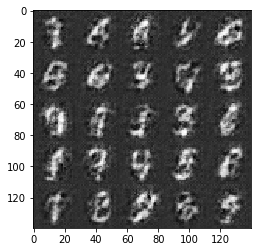

Epoch 2/2: batch 805/936: 	time/batch: 0.47s	remaining time: 61s 	d_loss: 0.2542	g_loss: 4.4313
Epoch 2/2: batch 810/936: 	time/batch: 0.47s	remaining time: 59s 	d_loss: 0.1752	g_loss: 3.2465
Epoch 2/2: batch 815/936: 	time/batch: 0.47s	remaining time: 57s 	d_loss: 0.1032	g_loss: 3.7242
Epoch 2/2: batch 820/936: 	time/batch: 0.47s	remaining time: 54s 	d_loss: 0.1266	g_loss: 3.7068
Epoch 2/2: batch 825/936: 	time/batch: 0.47s	remaining time: 52s 	d_loss: 0.1983	g_loss: 2.1082
Epoch 2/2: batch 830/936: 	time/batch: 0.47s	remaining time: 50s 	d_loss: 0.3188	g_loss: 1.5961
Epoch 2/2: batch 835/936: 	time/batch: 0.47s	remaining time: 47s 	d_loss: 0.0471	g_loss: 4.6234
Epoch 2/2: batch 840/936: 	time/batch: 0.47s	remaining time: 45s 	d_loss: 0.1327	g_loss: 2.5195
Epoch 2/2: batch 845/936: 	time/batch: 0.47s	remaining time: 42s 	d_loss: 0.1945	g_loss: 3.9000
Epoch 2/2: batch 850/936: 	time/batch: 0.47s	remaining time: 40s 	d_loss: 0.0999	g_loss: 3.3282
Epoch 2/2: batch 855/936: 	time/batch: 0

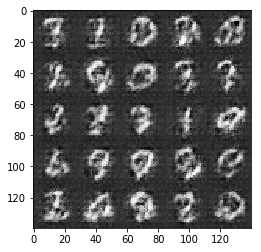

Epoch 2/2: batch 905/936: 	time/batch: 0.47s	remaining time: 14s 	d_loss: 0.3128	g_loss: 2.6123
Epoch 2/2: batch 910/936: 	time/batch: 0.47s	remaining time: 12s 	d_loss: 0.3752	g_loss: 1.5231
Epoch 2/2: batch 915/936: 	time/batch: 0.47s	remaining time: 9s 	d_loss: 0.2971	g_loss: 2.0370
Epoch 2/2: batch 920/936: 	time/batch: 0.47s	remaining time: 7s 	d_loss: 0.5741	g_loss: 0.9788
Epoch 2/2: batch 925/936: 	time/batch: 0.47s	remaining time: 5s 	d_loss: 0.1505	g_loss: 2.6015
Epoch 2/2: batch 930/936: 	time/batch: 0.47s	remaining time: 2s 	d_loss: 0.0941	g_loss: 2.9141
Epoch 2/2: batch 935/936: 	time/batch: 0.47s	remaining time: 0s 	d_loss: 0.1582	g_loss: 2.6417


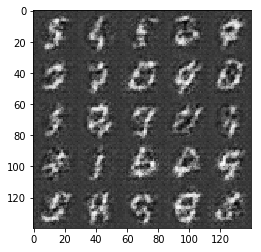

In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

d_losses = []
g_losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    # jcc: added lists for plotting discriminator and generator losses
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

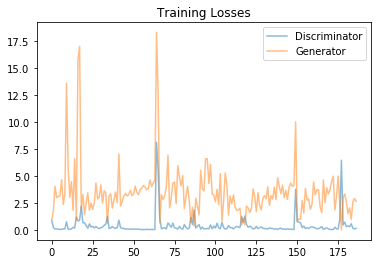

In [21]:
plot_losses(d_losses, g_losses)

### Third run: decrease learning rate
Hyperparameters:
- batch_size = 128
- z_dim = 100
- learning_rate = 0.0001
- beta1 = 0.5
- alpha = 0.2

Generator (back to original CNN layers)
- layer 1: 4x4x512 with LRELU
- layer 2: 7x7x256 with LRELU
- layer 3: 14x14x128 with LRELU
- layer 4: 28x28xOutput_Channel with TANH

Epoch 1/2: batch 5/936: 	time/batch: 1.21s	remaining time: 1127s 	d_loss: 1.4329	g_loss: 0.6385
Epoch 1/2: batch 10/936: 	time/batch: 0.77s	remaining time: 715s 	d_loss: 1.1054	g_loss: 0.6250
Epoch 1/2: batch 15/936: 	time/batch: 0.62s	remaining time: 575s 	d_loss: 0.4799	g_loss: 1.2395
Epoch 1/2: batch 20/936: 	time/batch: 0.55s	remaining time: 505s 	d_loss: 0.4985	g_loss: 1.3163
Epoch 1/2: batch 25/936: 	time/batch: 0.51s	remaining time: 462s 	d_loss: 0.5003	g_loss: 1.6100
Epoch 1/2: batch 30/936: 	time/batch: 0.48s	remaining time: 433s 	d_loss: 0.3722	g_loss: 1.7224
Epoch 1/2: batch 35/936: 	time/batch: 0.46s	remaining time: 411s 	d_loss: 0.7261	g_loss: 0.9941
Epoch 1/2: batch 40/936: 	time/batch: 0.44s	remaining time: 395s 	d_loss: 1.2767	g_loss: 0.4506
Epoch 1/2: batch 45/936: 	time/batch: 0.43s	remaining time: 381s 	d_loss: 1.0064	g_loss: 2.0410
Epoch 1/2: batch 50/936: 	time/batch: 0.42s	remaining time: 371s 	d_loss: 0.6482	g_loss: 1.1531
Epoch 1/2: batch 55/936: 	time/batch: 0.

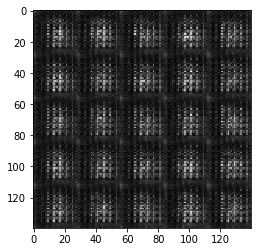

Epoch 1/2: batch 105/936: 	time/batch: 0.38s	remaining time: 312s 	d_loss: 0.3942	g_loss: 1.9560
Epoch 1/2: batch 110/936: 	time/batch: 0.37s	remaining time: 309s 	d_loss: 0.2523	g_loss: 2.4142
Epoch 1/2: batch 115/936: 	time/batch: 0.37s	remaining time: 305s 	d_loss: 0.2524	g_loss: 2.2640
Epoch 1/2: batch 120/936: 	time/batch: 0.37s	remaining time: 302s 	d_loss: 0.2197	g_loss: 2.3355
Epoch 1/2: batch 125/936: 	time/batch: 0.37s	remaining time: 299s 	d_loss: 0.1503	g_loss: 2.7586
Epoch 1/2: batch 130/936: 	time/batch: 0.37s	remaining time: 295s 	d_loss: 0.1592	g_loss: 2.6283
Epoch 1/2: batch 135/936: 	time/batch: 0.37s	remaining time: 292s 	d_loss: 0.2768	g_loss: 2.2787
Epoch 1/2: batch 140/936: 	time/batch: 0.36s	remaining time: 290s 	d_loss: 0.2062	g_loss: 2.5655
Epoch 1/2: batch 145/936: 	time/batch: 0.36s	remaining time: 287s 	d_loss: 0.2817	g_loss: 2.0529
Epoch 1/2: batch 150/936: 	time/batch: 0.36s	remaining time: 284s 	d_loss: 0.5488	g_loss: 4.6196
Epoch 1/2: batch 155/936: 	tim

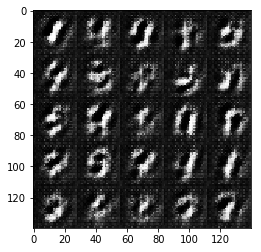

Epoch 1/2: batch 205/936: 	time/batch: 0.35s	remaining time: 259s 	d_loss: 0.3796	g_loss: 1.8947
Epoch 1/2: batch 210/936: 	time/batch: 0.35s	remaining time: 256s 	d_loss: 0.2202	g_loss: 2.4885
Epoch 1/2: batch 215/936: 	time/batch: 0.35s	remaining time: 254s 	d_loss: 0.2690	g_loss: 2.0299
Epoch 1/2: batch 220/936: 	time/batch: 0.35s	remaining time: 252s 	d_loss: 0.3802	g_loss: 1.6483
Epoch 1/2: batch 225/936: 	time/batch: 0.35s	remaining time: 250s 	d_loss: 0.2363	g_loss: 2.3308
Epoch 1/2: batch 230/936: 	time/batch: 0.35s	remaining time: 247s 	d_loss: 0.2454	g_loss: 2.4756
Epoch 1/2: batch 235/936: 	time/batch: 0.35s	remaining time: 245s 	d_loss: 0.3370	g_loss: 1.5724
Epoch 1/2: batch 240/936: 	time/batch: 0.35s	remaining time: 243s 	d_loss: 0.2918	g_loss: 3.6854
Epoch 1/2: batch 245/936: 	time/batch: 0.35s	remaining time: 241s 	d_loss: 0.3297	g_loss: 3.5396
Epoch 1/2: batch 250/936: 	time/batch: 0.35s	remaining time: 239s 	d_loss: 0.2401	g_loss: 1.9999
Epoch 1/2: batch 255/936: 	tim

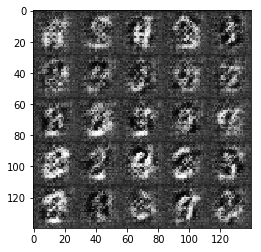

Epoch 1/2: batch 305/936: 	time/batch: 0.35s	remaining time: 218s 	d_loss: 0.4287	g_loss: 1.5976
Epoch 1/2: batch 310/936: 	time/batch: 0.35s	remaining time: 216s 	d_loss: 2.0442	g_loss: 0.1788
Epoch 1/2: batch 315/936: 	time/batch: 0.34s	remaining time: 214s 	d_loss: 1.8946	g_loss: 4.6360
Epoch 1/2: batch 320/936: 	time/batch: 0.34s	remaining time: 212s 	d_loss: 0.3787	g_loss: 1.6337
Epoch 1/2: batch 325/936: 	time/batch: 0.34s	remaining time: 210s 	d_loss: 1.0378	g_loss: 9.2253
Epoch 1/2: batch 330/936: 	time/batch: 0.34s	remaining time: 208s 	d_loss: 0.8809	g_loss: 0.7989
Epoch 1/2: batch 335/936: 	time/batch: 0.34s	remaining time: 206s 	d_loss: 1.2434	g_loss: 2.0926
Epoch 1/2: batch 340/936: 	time/batch: 0.34s	remaining time: 204s 	d_loss: 1.0888	g_loss: 3.9130
Epoch 1/2: batch 345/936: 	time/batch: 0.34s	remaining time: 202s 	d_loss: 0.4681	g_loss: 1.6326
Epoch 1/2: batch 350/936: 	time/batch: 0.34s	remaining time: 200s 	d_loss: 0.2851	g_loss: 2.5636
Epoch 1/2: batch 355/936: 	tim

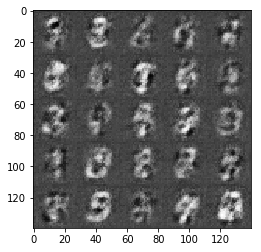

Epoch 1/2: batch 405/936: 	time/batch: 0.34s	remaining time: 181s 	d_loss: 0.4025	g_loss: 1.5784
Epoch 1/2: batch 410/936: 	time/batch: 0.34s	remaining time: 179s 	d_loss: 0.3159	g_loss: 2.2223
Epoch 1/2: batch 415/936: 	time/batch: 0.34s	remaining time: 177s 	d_loss: 0.4072	g_loss: 1.5854
Epoch 1/2: batch 420/936: 	time/batch: 0.34s	remaining time: 176s 	d_loss: 0.3055	g_loss: 2.4513
Epoch 1/2: batch 425/936: 	time/batch: 0.34s	remaining time: 174s 	d_loss: 0.3799	g_loss: 1.6171
Epoch 1/2: batch 430/936: 	time/batch: 0.34s	remaining time: 172s 	d_loss: 0.3357	g_loss: 2.3928
Epoch 1/2: batch 435/936: 	time/batch: 0.34s	remaining time: 170s 	d_loss: 1.0834	g_loss: 0.5148
Epoch 1/2: batch 440/936: 	time/batch: 0.34s	remaining time: 168s 	d_loss: 0.3776	g_loss: 2.2632
Epoch 1/2: batch 445/936: 	time/batch: 0.34s	remaining time: 167s 	d_loss: 0.3165	g_loss: 1.8103
Epoch 1/2: batch 450/936: 	time/batch: 0.34s	remaining time: 165s 	d_loss: 0.4284	g_loss: 1.4744
Epoch 1/2: batch 455/936: 	tim

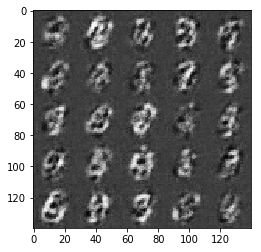

Epoch 2/2: batch 505/936: 	time/batch: 0.33s	remaining time: 143s 	d_loss: 0.3290	g_loss: 1.7751
Epoch 2/2: batch 510/936: 	time/batch: 0.33s	remaining time: 141s 	d_loss: 0.2931	g_loss: 2.3214
Epoch 2/2: batch 515/936: 	time/batch: 0.33s	remaining time: 139s 	d_loss: 0.2587	g_loss: 2.2431
Epoch 2/2: batch 520/936: 	time/batch: 0.33s	remaining time: 137s 	d_loss: 0.2731	g_loss: 2.5313
Epoch 2/2: batch 525/936: 	time/batch: 0.33s	remaining time: 135s 	d_loss: 0.2522	g_loss: 2.3794
Epoch 2/2: batch 530/936: 	time/batch: 0.33s	remaining time: 133s 	d_loss: 0.2561	g_loss: 2.3180
Epoch 2/2: batch 535/936: 	time/batch: 0.33s	remaining time: 131s 	d_loss: 0.2773	g_loss: 2.0282
Epoch 2/2: batch 540/936: 	time/batch: 0.33s	remaining time: 129s 	d_loss: 0.2722	g_loss: 2.4043
Epoch 2/2: batch 545/936: 	time/batch: 0.33s	remaining time: 127s 	d_loss: 0.3085	g_loss: 2.8020
Epoch 2/2: batch 550/936: 	time/batch: 0.32s	remaining time: 125s 	d_loss: 0.2266	g_loss: 2.4208
Epoch 2/2: batch 555/936: 	tim

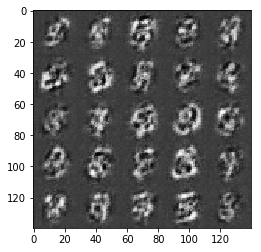

Epoch 2/2: batch 605/936: 	time/batch: 0.32s	remaining time: 105s 	d_loss: 0.2285	g_loss: 3.1370
Epoch 2/2: batch 610/936: 	time/batch: 0.32s	remaining time: 103s 	d_loss: 0.2198	g_loss: 2.4465
Epoch 2/2: batch 615/936: 	time/batch: 0.32s	remaining time: 101s 	d_loss: 0.2240	g_loss: 2.0950
Epoch 2/2: batch 620/936: 	time/batch: 0.32s	remaining time: 99s 	d_loss: 0.2624	g_loss: 1.9595
Epoch 2/2: batch 625/936: 	time/batch: 0.31s	remaining time: 97s 	d_loss: 0.2525	g_loss: 2.6910
Epoch 2/2: batch 630/936: 	time/batch: 0.31s	remaining time: 96s 	d_loss: 1.6535	g_loss: 0.2853
Epoch 2/2: batch 635/936: 	time/batch: 0.31s	remaining time: 94s 	d_loss: 0.2930	g_loss: 2.5703
Epoch 2/2: batch 640/936: 	time/batch: 0.31s	remaining time: 92s 	d_loss: 0.2092	g_loss: 2.3182
Epoch 2/2: batch 645/936: 	time/batch: 0.31s	remaining time: 90s 	d_loss: 0.2366	g_loss: 2.0274
Epoch 2/2: batch 650/936: 	time/batch: 0.31s	remaining time: 89s 	d_loss: 0.2172	g_loss: 2.3005
Epoch 2/2: batch 655/936: 	time/batch

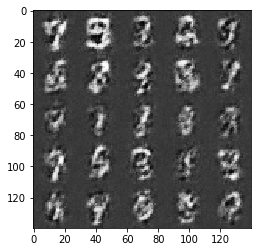

Epoch 2/2: batch 705/936: 	time/batch: 0.31s	remaining time: 70s 	d_loss: 0.1366	g_loss: 2.7846
Epoch 2/2: batch 710/936: 	time/batch: 0.31s	remaining time: 69s 	d_loss: 0.1713	g_loss: 2.3927
Epoch 2/2: batch 715/936: 	time/batch: 0.31s	remaining time: 67s 	d_loss: 0.1752	g_loss: 2.3444
Epoch 2/2: batch 720/936: 	time/batch: 0.31s	remaining time: 65s 	d_loss: 0.1320	g_loss: 2.8439
Epoch 2/2: batch 725/936: 	time/batch: 0.30s	remaining time: 64s 	d_loss: 0.1555	g_loss: 3.2653
Epoch 2/2: batch 730/936: 	time/batch: 0.30s	remaining time: 62s 	d_loss: 0.1195	g_loss: 3.1984
Epoch 2/2: batch 735/936: 	time/batch: 0.30s	remaining time: 61s 	d_loss: 0.1169	g_loss: 3.0969
Epoch 2/2: batch 740/936: 	time/batch: 0.30s	remaining time: 59s 	d_loss: 0.1514	g_loss: 2.6620
Epoch 2/2: batch 745/936: 	time/batch: 0.30s	remaining time: 57s 	d_loss: 0.1966	g_loss: 2.1612
Epoch 2/2: batch 750/936: 	time/batch: 0.30s	remaining time: 56s 	d_loss: 0.1507	g_loss: 2.9704
Epoch 2/2: batch 755/936: 	time/batch: 0

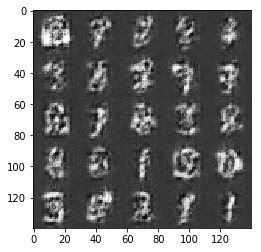

Epoch 2/2: batch 805/936: 	time/batch: 0.30s	remaining time: 39s 	d_loss: 0.2795	g_loss: 1.8264
Epoch 2/2: batch 810/936: 	time/batch: 0.30s	remaining time: 37s 	d_loss: 0.2020	g_loss: 2.6575
Epoch 2/2: batch 815/936: 	time/batch: 0.30s	remaining time: 36s 	d_loss: 0.1544	g_loss: 2.5996
Epoch 2/2: batch 820/936: 	time/batch: 0.30s	remaining time: 34s 	d_loss: 0.1820	g_loss: 2.6499
Epoch 2/2: batch 825/936: 	time/batch: 0.30s	remaining time: 32s 	d_loss: 0.1467	g_loss: 2.7715
Epoch 2/2: batch 830/936: 	time/batch: 0.30s	remaining time: 31s 	d_loss: 0.1374	g_loss: 2.7562
Epoch 2/2: batch 835/936: 	time/batch: 0.30s	remaining time: 29s 	d_loss: 0.1267	g_loss: 2.7650
Epoch 2/2: batch 840/936: 	time/batch: 0.30s	remaining time: 28s 	d_loss: 0.1442	g_loss: 2.6666
Epoch 2/2: batch 845/936: 	time/batch: 0.30s	remaining time: 26s 	d_loss: 0.1443	g_loss: 2.7610
Epoch 2/2: batch 850/936: 	time/batch: 0.30s	remaining time: 25s 	d_loss: 0.1255	g_loss: 2.8264
Epoch 2/2: batch 855/936: 	time/batch: 0

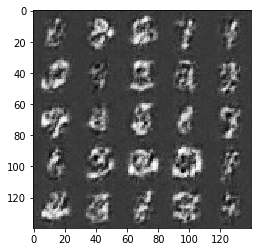

Epoch 2/2: batch 905/936: 	time/batch: 0.29s	remaining time: 9s 	d_loss: 0.1164	g_loss: 2.9158
Epoch 2/2: batch 910/936: 	time/batch: 0.29s	remaining time: 7s 	d_loss: 0.1065	g_loss: 2.9037
Epoch 2/2: batch 915/936: 	time/batch: 0.29s	remaining time: 6s 	d_loss: 0.1028	g_loss: 3.1247
Epoch 2/2: batch 920/936: 	time/batch: 0.29s	remaining time: 4s 	d_loss: 0.1057	g_loss: 2.9708
Epoch 2/2: batch 925/936: 	time/batch: 0.29s	remaining time: 3s 	d_loss: 0.1707	g_loss: 2.3827
Epoch 2/2: batch 930/936: 	time/batch: 0.29s	remaining time: 1s 	d_loss: 0.1273	g_loss: 2.7991
Epoch 2/2: batch 935/936: 	time/batch: 0.29s	remaining time: 0s 	d_loss: 0.1176	g_loss: 2.8449


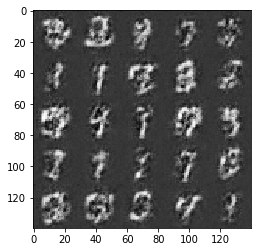

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

d_losses = []
g_losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    # jcc: added lists for plotting discriminator and generator losses
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

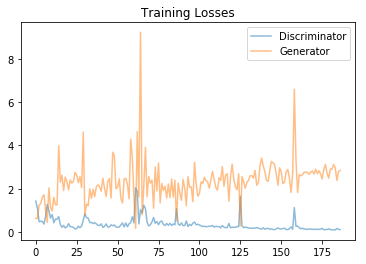

In [13]:
plot_losses(d_losses, g_losses)

### Fourth run: try increasing the batch size?

Epoch 1/2: batch 5/468: 	time/batch: 0.74s	remaining time: 341s 	d_loss: 1.2813	g_loss: 0.5564
Epoch 1/2: batch 10/468: 	time/batch: 0.60s	remaining time: 272s 	d_loss: 0.8440	g_loss: 1.0607
Epoch 1/2: batch 15/468: 	time/batch: 0.55s	remaining time: 247s 	d_loss: 0.5371	g_loss: 1.2694
Epoch 1/2: batch 20/468: 	time/batch: 0.52s	remaining time: 233s 	d_loss: 0.5548	g_loss: 1.4705
Epoch 1/2: batch 25/468: 	time/batch: 0.51s	remaining time: 224s 	d_loss: 0.7235	g_loss: 1.3155
Epoch 1/2: batch 30/468: 	time/batch: 0.50s	remaining time: 217s 	d_loss: 0.6732	g_loss: 1.1197
Epoch 1/2: batch 35/468: 	time/batch: 0.49s	remaining time: 212s 	d_loss: 0.7420	g_loss: 1.2038
Epoch 1/2: batch 40/468: 	time/batch: 0.49s	remaining time: 207s 	d_loss: 0.8918	g_loss: 1.1170
Epoch 1/2: batch 45/468: 	time/batch: 0.48s	remaining time: 203s 	d_loss: 1.1877	g_loss: 0.8938
Epoch 1/2: batch 50/468: 	time/batch: 0.48s	remaining time: 199s 	d_loss: 0.8940	g_loss: 2.3375
Epoch 1/2: batch 55/468: 	time/batch: 0.4

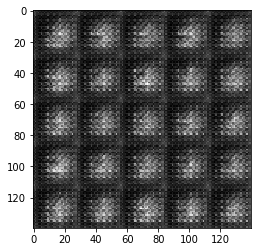

Epoch 1/2: batch 105/468: 	time/batch: 0.47s	remaining time: 168s 	d_loss: 0.3422	g_loss: 2.0046
Epoch 1/2: batch 110/468: 	time/batch: 0.46s	remaining time: 166s 	d_loss: 0.4857	g_loss: 1.5712
Epoch 1/2: batch 115/468: 	time/batch: 0.46s	remaining time: 163s 	d_loss: 0.4623	g_loss: 2.9911
Epoch 1/2: batch 120/468: 	time/batch: 0.46s	remaining time: 161s 	d_loss: 0.3926	g_loss: 2.2301
Epoch 1/2: batch 125/468: 	time/batch: 0.46s	remaining time: 158s 	d_loss: 0.4933	g_loss: 1.8445
Epoch 1/2: batch 130/468: 	time/batch: 0.46s	remaining time: 156s 	d_loss: 0.9180	g_loss: 0.7045
Epoch 1/2: batch 135/468: 	time/batch: 0.46s	remaining time: 153s 	d_loss: 0.5986	g_loss: 1.4929
Epoch 1/2: batch 140/468: 	time/batch: 0.46s	remaining time: 151s 	d_loss: 0.8603	g_loss: 2.9192
Epoch 1/2: batch 145/468: 	time/batch: 0.46s	remaining time: 149s 	d_loss: 0.6690	g_loss: 1.6505
Epoch 1/2: batch 150/468: 	time/batch: 0.46s	remaining time: 146s 	d_loss: 0.5961	g_loss: 1.2654
Epoch 1/2: batch 155/468: 	tim

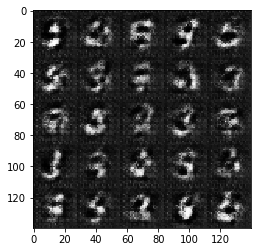

Epoch 1/2: batch 205/468: 	time/batch: 0.46s	remaining time: 120s 	d_loss: 0.4105	g_loss: 1.8414
Epoch 1/2: batch 210/468: 	time/batch: 0.46s	remaining time: 118s 	d_loss: 0.2869	g_loss: 2.0082
Epoch 1/2: batch 215/468: 	time/batch: 0.46s	remaining time: 116s 	d_loss: 0.2923	g_loss: 2.2122
Epoch 1/2: batch 220/468: 	time/batch: 0.46s	remaining time: 113s 	d_loss: 0.3348	g_loss: 2.8735
Epoch 1/2: batch 225/468: 	time/batch: 0.46s	remaining time: 111s 	d_loss: 0.2962	g_loss: 2.1972
Epoch 1/2: batch 230/468: 	time/batch: 0.46s	remaining time: 109s 	d_loss: 0.2518	g_loss: 2.4688
Epoch 2/2: batch 235/468: 	time/batch: 0.46s	remaining time: 106s 	d_loss: 0.2587	g_loss: 2.1534
Epoch 2/2: batch 240/468: 	time/batch: 0.46s	remaining time: 104s 	d_loss: 3.8103	g_loss: 0.0289
Epoch 2/2: batch 245/468: 	time/batch: 0.46s	remaining time: 102s 	d_loss: 0.5706	g_loss: 1.0987
Epoch 2/2: batch 250/468: 	time/batch: 0.46s	remaining time: 99s 	d_loss: 0.4202	g_loss: 2.8859
Epoch 2/2: batch 255/468: 	time

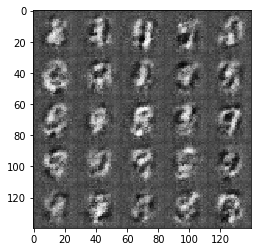

Epoch 2/2: batch 305/468: 	time/batch: 0.46s	remaining time: 74s 	d_loss: 0.4293	g_loss: 3.7139
Epoch 2/2: batch 310/468: 	time/batch: 0.46s	remaining time: 72s 	d_loss: 1.3610	g_loss: 0.4191
Epoch 2/2: batch 315/468: 	time/batch: 0.46s	remaining time: 69s 	d_loss: 0.2884	g_loss: 2.2494
Epoch 2/2: batch 320/468: 	time/batch: 0.46s	remaining time: 67s 	d_loss: 0.7427	g_loss: 1.2298
Epoch 2/2: batch 325/468: 	time/batch: 0.46s	remaining time: 65s 	d_loss: 0.4224	g_loss: 1.8615
Epoch 2/2: batch 330/468: 	time/batch: 0.46s	remaining time: 63s 	d_loss: 0.4429	g_loss: 1.8366
Epoch 2/2: batch 335/468: 	time/batch: 0.46s	remaining time: 60s 	d_loss: 0.3445	g_loss: 2.2726
Epoch 2/2: batch 340/468: 	time/batch: 0.46s	remaining time: 58s 	d_loss: 0.3268	g_loss: 2.0926
Epoch 2/2: batch 345/468: 	time/batch: 0.46s	remaining time: 56s 	d_loss: 0.3474	g_loss: 2.2671
Epoch 2/2: batch 350/468: 	time/batch: 0.46s	remaining time: 53s 	d_loss: 0.3812	g_loss: 1.7785
Epoch 2/2: batch 355/468: 	time/batch: 0

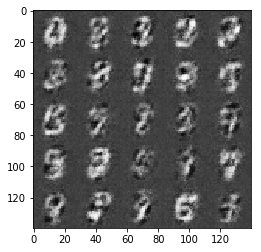

Epoch 2/2: batch 405/468: 	time/batch: 0.46s	remaining time: 28s 	d_loss: 0.3570	g_loss: 1.6303
Epoch 2/2: batch 410/468: 	time/batch: 0.46s	remaining time: 26s 	d_loss: 0.3450	g_loss: 1.6619
Epoch 2/2: batch 415/468: 	time/batch: 0.46s	remaining time: 24s 	d_loss: 0.3174	g_loss: 2.3983
Epoch 2/2: batch 420/468: 	time/batch: 0.46s	remaining time: 21s 	d_loss: 0.4030	g_loss: 1.3715
Epoch 2/2: batch 425/468: 	time/batch: 0.46s	remaining time: 19s 	d_loss: 0.2745	g_loss: 2.2267
Epoch 2/2: batch 430/468: 	time/batch: 0.46s	remaining time: 17s 	d_loss: 0.2884	g_loss: 2.5588
Epoch 2/2: batch 435/468: 	time/batch: 0.46s	remaining time: 15s 	d_loss: 0.2378	g_loss: 2.1932
Epoch 2/2: batch 440/468: 	time/batch: 0.46s	remaining time: 12s 	d_loss: 0.3111	g_loss: 2.5799
Epoch 2/2: batch 445/468: 	time/batch: 0.46s	remaining time: 10s 	d_loss: 0.3013	g_loss: 2.7344
Epoch 2/2: batch 450/468: 	time/batch: 0.46s	remaining time: 8s 	d_loss: 0.3691	g_loss: 1.5765
Epoch 2/2: batch 455/468: 	time/batch: 0.

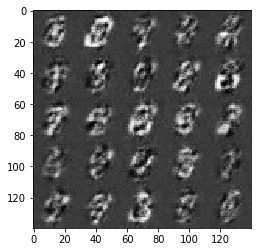

In [14]:
batch_size = 256
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

d_losses = []
g_losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    # jcc: added lists for plotting discriminator and generator losses
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

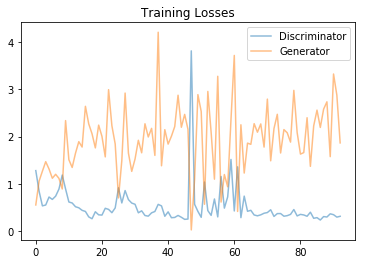

In [15]:
plot_losses(d_losses, g_losses)

### Fifth run
Looking at the previous runs, it seems that the only run with possibly decreasing generator loss was the second, with a deeper initial input layer. So we'll try that again, and adjust the learning rate.

Hyperparameters:
- batch_size = 128
- z_dim = 100
- learning_rate = 0.0001
- beta1 = 0.5
- alpha = 0.2

Generator:
- layer 1: 4x4x1024 with LRELU
- layer 2: 7x7x512 with LRELU
- layer 3: 14x14x256 with LRELU
- layer 4: 28x28xOutput_Channel with TANH

Epoch 1/2: batch 5/936: 	time/batch: 0.92s	remaining time: 856s 	d_loss: 2.2286	g_loss: 0.1960
Epoch 1/2: batch 10/936: 	time/batch: 0.71s	remaining time: 657s 	d_loss: 1.0887	g_loss: 0.7345
Epoch 1/2: batch 15/936: 	time/batch: 0.64s	remaining time: 589s 	d_loss: 0.5712	g_loss: 1.2440
Epoch 1/2: batch 20/936: 	time/batch: 0.60s	remaining time: 553s 	d_loss: 0.2433	g_loss: 2.0514
Epoch 1/2: batch 25/936: 	time/batch: 0.58s	remaining time: 531s 	d_loss: 0.2617	g_loss: 1.9292
Epoch 1/2: batch 30/936: 	time/batch: 0.57s	remaining time: 515s 	d_loss: 0.2003	g_loss: 2.0346
Epoch 1/2: batch 35/936: 	time/batch: 0.56s	remaining time: 502s 	d_loss: 0.3206	g_loss: 2.1046
Epoch 1/2: batch 40/936: 	time/batch: 0.55s	remaining time: 493s 	d_loss: 0.2887	g_loss: 2.4074
Epoch 1/2: batch 45/936: 	time/batch: 0.54s	remaining time: 485s 	d_loss: 0.3515	g_loss: 1.5628
Epoch 1/2: batch 50/936: 	time/batch: 0.54s	remaining time: 478s 	d_loss: 0.2300	g_loss: 2.4623
Epoch 1/2: batch 55/936: 	time/batch: 0.5

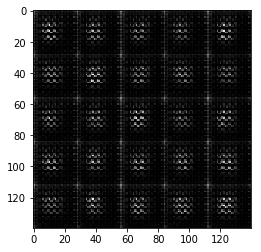

Epoch 1/2: batch 105/936: 	time/batch: 0.52s	remaining time: 434s 	d_loss: 0.2098	g_loss: 4.5475
Epoch 1/2: batch 110/936: 	time/batch: 0.52s	remaining time: 431s 	d_loss: 0.2752	g_loss: 1.6312
Epoch 1/2: batch 115/936: 	time/batch: 0.52s	remaining time: 427s 	d_loss: 0.3649	g_loss: 1.8020
Epoch 1/2: batch 120/936: 	time/batch: 0.52s	remaining time: 424s 	d_loss: 0.2059	g_loss: 2.4093
Epoch 1/2: batch 125/936: 	time/batch: 0.52s	remaining time: 421s 	d_loss: 0.9274	g_loss: 5.4360
Epoch 1/2: batch 130/936: 	time/batch: 0.52s	remaining time: 417s 	d_loss: 0.3037	g_loss: 3.2924
Epoch 1/2: batch 135/936: 	time/batch: 0.52s	remaining time: 414s 	d_loss: 0.1477	g_loss: 3.2139
Epoch 1/2: batch 140/936: 	time/batch: 0.52s	remaining time: 411s 	d_loss: 0.1205	g_loss: 2.7957
Epoch 1/2: batch 145/936: 	time/batch: 0.52s	remaining time: 408s 	d_loss: 0.0935	g_loss: 4.0490
Epoch 1/2: batch 150/936: 	time/batch: 0.52s	remaining time: 405s 	d_loss: 0.0844	g_loss: 3.1915
Epoch 1/2: batch 155/936: 	tim

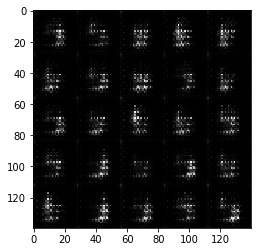

Epoch 1/2: batch 205/936: 	time/batch: 0.51s	remaining time: 374s 	d_loss: 0.1641	g_loss: 3.0958
Epoch 1/2: batch 210/936: 	time/batch: 0.51s	remaining time: 372s 	d_loss: 0.1329	g_loss: 3.1507
Epoch 1/2: batch 215/936: 	time/batch: 0.51s	remaining time: 369s 	d_loss: 0.1336	g_loss: 3.6144
Epoch 1/2: batch 220/936: 	time/batch: 0.51s	remaining time: 366s 	d_loss: 0.1284	g_loss: 3.1705
Epoch 1/2: batch 225/936: 	time/batch: 0.51s	remaining time: 363s 	d_loss: 0.1673	g_loss: 3.1704
Epoch 1/2: batch 230/936: 	time/batch: 0.51s	remaining time: 361s 	d_loss: 0.1243	g_loss: 3.2539
Epoch 1/2: batch 235/936: 	time/batch: 0.51s	remaining time: 358s 	d_loss: 0.2035	g_loss: 2.3749
Epoch 1/2: batch 240/936: 	time/batch: 0.51s	remaining time: 355s 	d_loss: 0.1627	g_loss: 2.6888
Epoch 1/2: batch 245/936: 	time/batch: 0.51s	remaining time: 352s 	d_loss: 0.3060	g_loss: 1.9141
Epoch 1/2: batch 250/936: 	time/batch: 0.51s	remaining time: 350s 	d_loss: 1.2629	g_loss: 0.9578
Epoch 1/2: batch 255/936: 	tim

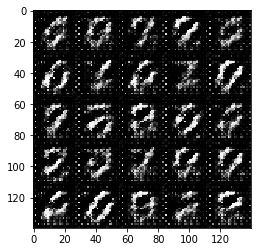

Epoch 1/2: batch 305/936: 	time/batch: 0.51s	remaining time: 321s 	d_loss: 0.1463	g_loss: 2.9473
Epoch 1/2: batch 310/936: 	time/batch: 0.51s	remaining time: 318s 	d_loss: 0.0961	g_loss: 3.0889
Epoch 1/2: batch 315/936: 	time/batch: 0.51s	remaining time: 316s 	d_loss: 0.0985	g_loss: 3.1709
Epoch 1/2: batch 320/936: 	time/batch: 0.51s	remaining time: 313s 	d_loss: 0.1315	g_loss: 2.7960
Epoch 1/2: batch 325/936: 	time/batch: 0.51s	remaining time: 311s 	d_loss: 0.1008	g_loss: 3.1272
Epoch 1/2: batch 330/936: 	time/batch: 0.51s	remaining time: 308s 	d_loss: 0.1326	g_loss: 3.4439
Epoch 1/2: batch 335/936: 	time/batch: 0.51s	remaining time: 305s 	d_loss: 0.1230	g_loss: 2.7407
Epoch 1/2: batch 340/936: 	time/batch: 0.51s	remaining time: 303s 	d_loss: 0.1326	g_loss: 2.8378
Epoch 1/2: batch 345/936: 	time/batch: 0.51s	remaining time: 300s 	d_loss: 0.1055	g_loss: 2.9225
Epoch 1/2: batch 350/936: 	time/batch: 0.51s	remaining time: 297s 	d_loss: 0.1476	g_loss: 2.7391
Epoch 1/2: batch 355/936: 	tim

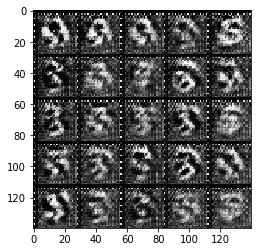

Epoch 1/2: batch 405/936: 	time/batch: 0.51s	remaining time: 269s 	d_loss: 0.0476	g_loss: 4.0713
Epoch 1/2: batch 410/936: 	time/batch: 0.51s	remaining time: 267s 	d_loss: 0.0481	g_loss: 4.3657
Epoch 1/2: batch 415/936: 	time/batch: 0.51s	remaining time: 264s 	d_loss: 0.1240	g_loss: 8.4986
Epoch 1/2: batch 420/936: 	time/batch: 0.51s	remaining time: 262s 	d_loss: 0.0531	g_loss: 5.3162
Epoch 1/2: batch 425/936: 	time/batch: 0.51s	remaining time: 259s 	d_loss: 0.0656	g_loss: 4.6414
Epoch 1/2: batch 430/936: 	time/batch: 0.51s	remaining time: 256s 	d_loss: 0.0589	g_loss: 3.0601
Epoch 1/2: batch 435/936: 	time/batch: 0.51s	remaining time: 254s 	d_loss: 0.1753	g_loss: 1.9870
Epoch 1/2: batch 440/936: 	time/batch: 0.51s	remaining time: 251s 	d_loss: 0.0370	g_loss: 7.7589
Epoch 1/2: batch 445/936: 	time/batch: 0.51s	remaining time: 249s 	d_loss: 0.0501	g_loss: 3.5111
Epoch 1/2: batch 450/936: 	time/batch: 0.51s	remaining time: 246s 	d_loss: 0.0202	g_loss: 4.9933
Epoch 1/2: batch 455/936: 	tim

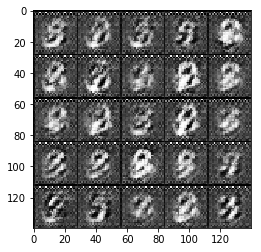

Epoch 2/2: batch 505/936: 	time/batch: 0.51s	remaining time: 218s 	d_loss: 0.0217	g_loss: 4.6462
Epoch 2/2: batch 510/936: 	time/batch: 0.51s	remaining time: 216s 	d_loss: 0.0194	g_loss: 4.6127
Epoch 2/2: batch 515/936: 	time/batch: 0.51s	remaining time: 213s 	d_loss: 0.0446	g_loss: 3.6616
Epoch 2/2: batch 520/936: 	time/batch: 0.51s	remaining time: 210s 	d_loss: 0.0124	g_loss: 5.1829
Epoch 2/2: batch 525/936: 	time/batch: 0.51s	remaining time: 208s 	d_loss: 0.0272	g_loss: 4.0910
Epoch 2/2: batch 530/936: 	time/batch: 0.51s	remaining time: 205s 	d_loss: 15.8181	g_loss: 17.0003
Epoch 2/2: batch 535/936: 	time/batch: 0.51s	remaining time: 203s 	d_loss: 0.1081	g_loss: 2.5702
Epoch 2/2: batch 540/936: 	time/batch: 0.51s	remaining time: 200s 	d_loss: 0.1602	g_loss: 2.6103
Epoch 2/2: batch 545/936: 	time/batch: 0.51s	remaining time: 198s 	d_loss: 0.1451	g_loss: 3.6579
Epoch 2/2: batch 550/936: 	time/batch: 0.51s	remaining time: 195s 	d_loss: 0.2032	g_loss: 6.4610
Epoch 2/2: batch 555/936: 	t

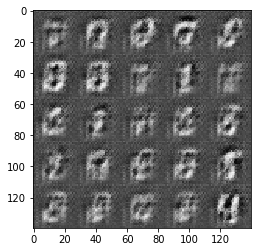

Epoch 2/2: batch 605/936: 	time/batch: 0.51s	remaining time: 167s 	d_loss: 0.5242	g_loss: 3.0685
Epoch 2/2: batch 610/936: 	time/batch: 0.51s	remaining time: 165s 	d_loss: 0.8391	g_loss: 0.8438
Epoch 2/2: batch 615/936: 	time/batch: 0.51s	remaining time: 162s 	d_loss: 0.5213	g_loss: 2.7979
Epoch 2/2: batch 620/936: 	time/batch: 0.51s	remaining time: 160s 	d_loss: 0.3285	g_loss: 3.2332
Epoch 2/2: batch 625/936: 	time/batch: 0.51s	remaining time: 157s 	d_loss: 0.5895	g_loss: 1.2332
Epoch 2/2: batch 630/936: 	time/batch: 0.51s	remaining time: 154s 	d_loss: 0.5199	g_loss: 1.4033
Epoch 2/2: batch 635/936: 	time/batch: 0.51s	remaining time: 152s 	d_loss: 0.5425	g_loss: 1.4145
Epoch 2/2: batch 640/936: 	time/batch: 0.51s	remaining time: 149s 	d_loss: 0.5600	g_loss: 2.7521
Epoch 2/2: batch 645/936: 	time/batch: 0.51s	remaining time: 147s 	d_loss: 0.5789	g_loss: 1.3135
Epoch 2/2: batch 650/936: 	time/batch: 0.51s	remaining time: 144s 	d_loss: 0.3258	g_loss: 3.2236
Epoch 2/2: batch 655/936: 	tim

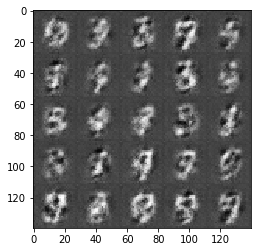

Epoch 2/2: batch 705/936: 	time/batch: 0.51s	remaining time: 116s 	d_loss: 0.4312	g_loss: 2.2950
Epoch 2/2: batch 710/936: 	time/batch: 0.51s	remaining time: 114s 	d_loss: 0.4632	g_loss: 1.3800
Epoch 2/2: batch 715/936: 	time/batch: 0.51s	remaining time: 111s 	d_loss: 0.3842	g_loss: 2.1352
Epoch 2/2: batch 720/936: 	time/batch: 0.51s	remaining time: 109s 	d_loss: 0.6885	g_loss: 3.5749
Epoch 2/2: batch 725/936: 	time/batch: 0.51s	remaining time: 106s 	d_loss: 0.3689	g_loss: 2.4032
Epoch 2/2: batch 730/936: 	time/batch: 0.51s	remaining time: 104s 	d_loss: 0.3392	g_loss: 2.2670
Epoch 2/2: batch 735/936: 	time/batch: 0.51s	remaining time: 101s 	d_loss: 0.3152	g_loss: 2.3175
Epoch 2/2: batch 740/936: 	time/batch: 0.51s	remaining time: 99s 	d_loss: 0.3954	g_loss: 2.2713
Epoch 2/2: batch 745/936: 	time/batch: 0.51s	remaining time: 96s 	d_loss: 0.4320	g_loss: 1.5866
Epoch 2/2: batch 750/936: 	time/batch: 0.51s	remaining time: 94s 	d_loss: 0.3657	g_loss: 2.3510
Epoch 2/2: batch 755/936: 	time/b

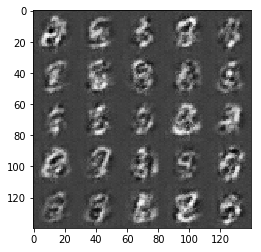

Epoch 2/2: batch 805/936: 	time/batch: 0.51s	remaining time: 66s 	d_loss: 0.3156	g_loss: 2.5124
Epoch 2/2: batch 810/936: 	time/batch: 0.51s	remaining time: 63s 	d_loss: 0.3758	g_loss: 1.6102
Epoch 2/2: batch 815/936: 	time/batch: 0.51s	remaining time: 61s 	d_loss: 0.9482	g_loss: 6.0304
Epoch 2/2: batch 820/936: 	time/batch: 0.51s	remaining time: 58s 	d_loss: 0.3634	g_loss: 2.3187
Epoch 2/2: batch 825/936: 	time/batch: 0.51s	remaining time: 56s 	d_loss: 0.2542	g_loss: 2.6316
Epoch 2/2: batch 830/936: 	time/batch: 0.51s	remaining time: 53s 	d_loss: 0.2643	g_loss: 2.0776
Epoch 2/2: batch 835/936: 	time/batch: 0.51s	remaining time: 51s 	d_loss: 0.3186	g_loss: 1.6980
Epoch 2/2: batch 840/936: 	time/batch: 0.51s	remaining time: 48s 	d_loss: 0.2429	g_loss: 2.7614
Epoch 2/2: batch 845/936: 	time/batch: 0.51s	remaining time: 46s 	d_loss: 0.2998	g_loss: 1.7567
Epoch 2/2: batch 850/936: 	time/batch: 0.51s	remaining time: 43s 	d_loss: 0.3548	g_loss: 3.3087
Epoch 2/2: batch 855/936: 	time/batch: 0

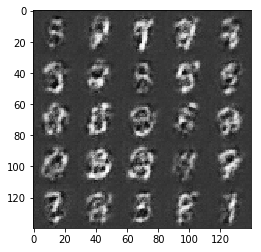

Epoch 2/2: batch 905/936: 	time/batch: 0.51s	remaining time: 15s 	d_loss: 0.1558	g_loss: 2.8558
Epoch 2/2: batch 910/936: 	time/batch: 0.51s	remaining time: 13s 	d_loss: 0.2246	g_loss: 2.3627
Epoch 2/2: batch 915/936: 	time/batch: 0.51s	remaining time: 10s 	d_loss: 0.1758	g_loss: 2.8229
Epoch 2/2: batch 920/936: 	time/batch: 0.51s	remaining time: 8s 	d_loss: 0.1833	g_loss: 3.1131
Epoch 2/2: batch 925/936: 	time/batch: 0.51s	remaining time: 5s 	d_loss: 0.2318	g_loss: 2.5917
Epoch 2/2: batch 930/936: 	time/batch: 0.51s	remaining time: 3s 	d_loss: 0.2182	g_loss: 2.6237
Epoch 2/2: batch 935/936: 	time/batch: 0.51s	remaining time: 0s 	d_loss: 1.3991	g_loss: 0.3403


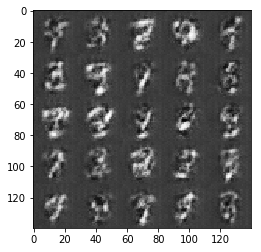

In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

d_losses = []
g_losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    # jcc: added lists for plotting discriminator and generator losses
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

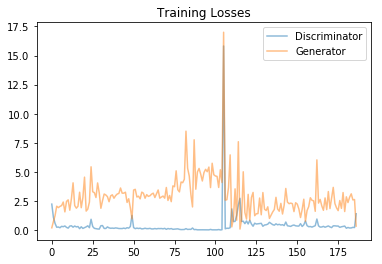

In [18]:
plot_losses(d_losses, g_losses)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1: batch 5/1582: 	time/batch: 0.71s	remaining time: 1127s 	d_loss: 1.9468	g_loss: 0.3531
Epoch 1/1: batch 10/1582: 	time/batch: 0.59s	remaining time: 927s 	d_loss: 1.0875	g_loss: 0.7400
Epoch 1/1: batch 15/1582: 	time/batch: 0.54s	remaining time: 842s 	d_loss: 0.2864	g_loss: 3.2613
Epoch 1/1: batch 20/1582: 	time/batch: 0.51s	remaining time: 797s 	d_loss: 0.2514	g_loss: 5.8986
Epoch 1/1: batch 25/1582: 	time/batch: 0.50s	remaining time: 771s 	d_loss: 0.2774	g_loss: 3.0339
Epoch 1/1: batch 30/1582: 	time/batch: 0.49s	remaining time: 754s 	d_loss: 0.6199	g_loss: 1.0687
Epoch 1/1: batch 35/1582: 	time/batch: 0.48s	remaining time: 739s 	d_loss: 0.2595	g_loss: 4.8671
Epoch 1/1: batch 40/1582: 	time/batch: 0.47s	remaining time: 728s 	d_loss: 0.2841	g_loss: 7.5103
Epoch 1/1: batch 45/1582: 	time/batch: 0.47s	remaining time: 719s 	d_loss: 0.1812	g_loss: 6.8762
Epoch 1/1: batch 50/1582: 	time/batch: 0.46s	remaining time: 711s 	d_loss: 0.2712	g_loss: 2.2599
Epoch 1/1: batch 55/1582: 	tim

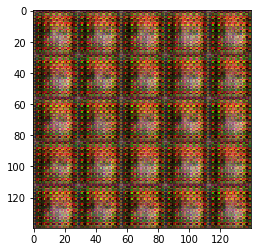

Epoch 1/1: batch 105/1582: 	time/batch: 0.45s	remaining time: 665s 	d_loss: 0.3259	g_loss: 9.3456
Epoch 1/1: batch 110/1582: 	time/batch: 0.45s	remaining time: 661s 	d_loss: 0.3341	g_loss: 1.5929
Epoch 1/1: batch 115/1582: 	time/batch: 0.45s	remaining time: 657s 	d_loss: 0.1763	g_loss: 2.9327
Epoch 1/1: batch 120/1582: 	time/batch: 0.45s	remaining time: 654s 	d_loss: 0.1408	g_loss: 3.9386
Epoch 1/1: batch 125/1582: 	time/batch: 0.45s	remaining time: 651s 	d_loss: 0.2397	g_loss: 1.9216
Epoch 1/1: batch 130/1582: 	time/batch: 0.45s	remaining time: 648s 	d_loss: 0.1092	g_loss: 4.4907
Epoch 1/1: batch 135/1582: 	time/batch: 0.45s	remaining time: 645s 	d_loss: 0.5164	g_loss: 0.9859
Epoch 1/1: batch 140/1582: 	time/batch: 0.45s	remaining time: 642s 	d_loss: 0.1506	g_loss: 7.4058
Epoch 1/1: batch 145/1582: 	time/batch: 0.44s	remaining time: 639s 	d_loss: 0.1030	g_loss: 3.8772
Epoch 1/1: batch 150/1582: 	time/batch: 0.44s	remaining time: 635s 	d_loss: 0.1251	g_loss: 3.0497
Epoch 1/1: batch 155

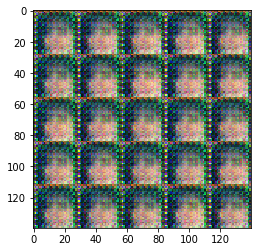

Epoch 1/1: batch 205/1582: 	time/batch: 0.44s	remaining time: 609s 	d_loss: 0.0576	g_loss: 3.2554
Epoch 1/1: batch 210/1582: 	time/batch: 0.44s	remaining time: 606s 	d_loss: 0.0341	g_loss: 3.9425
Epoch 1/1: batch 215/1582: 	time/batch: 0.44s	remaining time: 604s 	d_loss: 0.1072	g_loss: 3.7231
Epoch 1/1: batch 220/1582: 	time/batch: 0.44s	remaining time: 601s 	d_loss: 0.0805	g_loss: 7.8257
Epoch 1/1: batch 225/1582: 	time/batch: 0.44s	remaining time: 598s 	d_loss: 0.0464	g_loss: 3.5828
Epoch 1/1: batch 230/1582: 	time/batch: 0.44s	remaining time: 596s 	d_loss: 0.0432	g_loss: 3.8824
Epoch 1/1: batch 235/1582: 	time/batch: 0.44s	remaining time: 593s 	d_loss: 0.0207	g_loss: 7.0799
Epoch 1/1: batch 240/1582: 	time/batch: 0.44s	remaining time: 591s 	d_loss: 2.4325	g_loss: 22.7009
Epoch 1/1: batch 245/1582: 	time/batch: 0.44s	remaining time: 588s 	d_loss: 0.1312	g_loss: 2.1924
Epoch 1/1: batch 250/1582: 	time/batch: 0.44s	remaining time: 586s 	d_loss: 0.1937	g_loss: 2.3667
Epoch 1/1: batch 25

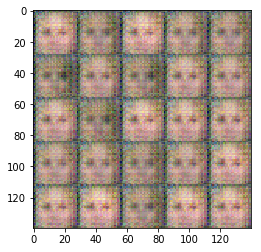

Epoch 1/1: batch 305/1582: 	time/batch: 0.44s	remaining time: 561s 	d_loss: 0.5150	g_loss: 2.7196
Epoch 1/1: batch 310/1582: 	time/batch: 0.44s	remaining time: 559s 	d_loss: 1.2505	g_loss: 0.5271
Epoch 1/1: batch 315/1582: 	time/batch: 0.44s	remaining time: 556s 	d_loss: 1.6735	g_loss: 0.2558
Epoch 1/1: batch 320/1582: 	time/batch: 0.44s	remaining time: 554s 	d_loss: 1.1653	g_loss: 1.1918
Epoch 1/1: batch 325/1582: 	time/batch: 0.44s	remaining time: 552s 	d_loss: 0.3477	g_loss: 2.5979
Epoch 1/1: batch 330/1582: 	time/batch: 0.44s	remaining time: 549s 	d_loss: 0.8350	g_loss: 1.8368
Epoch 1/1: batch 335/1582: 	time/batch: 0.44s	remaining time: 547s 	d_loss: 0.9537	g_loss: 2.5960
Epoch 1/1: batch 340/1582: 	time/batch: 0.44s	remaining time: 545s 	d_loss: 0.4956	g_loss: 3.1002
Epoch 1/1: batch 345/1582: 	time/batch: 0.44s	remaining time: 542s 	d_loss: 0.3486	g_loss: 2.8318
Epoch 1/1: batch 350/1582: 	time/batch: 0.44s	remaining time: 540s 	d_loss: 0.9268	g_loss: 0.8340
Epoch 1/1: batch 355

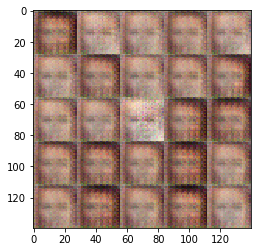

Epoch 1/1: batch 405/1582: 	time/batch: 0.44s	remaining time: 516s 	d_loss: 0.1880	g_loss: 5.0532
Epoch 1/1: batch 410/1582: 	time/batch: 0.44s	remaining time: 513s 	d_loss: 0.5065	g_loss: 2.1245
Epoch 1/1: batch 415/1582: 	time/batch: 0.44s	remaining time: 511s 	d_loss: 0.5731	g_loss: 1.6093
Epoch 1/1: batch 420/1582: 	time/batch: 0.44s	remaining time: 509s 	d_loss: 0.7848	g_loss: 6.3632
Epoch 1/1: batch 425/1582: 	time/batch: 0.44s	remaining time: 506s 	d_loss: 0.1069	g_loss: 5.8064
Epoch 1/1: batch 430/1582: 	time/batch: 0.44s	remaining time: 504s 	d_loss: 0.4115	g_loss: 1.9506
Epoch 1/1: batch 435/1582: 	time/batch: 0.44s	remaining time: 502s 	d_loss: 0.7701	g_loss: 2.0565
Epoch 1/1: batch 440/1582: 	time/batch: 0.44s	remaining time: 500s 	d_loss: 0.7325	g_loss: 2.0719
Epoch 1/1: batch 445/1582: 	time/batch: 0.44s	remaining time: 497s 	d_loss: 0.4902	g_loss: 1.3584
Epoch 1/1: batch 450/1582: 	time/batch: 0.44s	remaining time: 495s 	d_loss: 2.0403	g_loss: 5.4305
Epoch 1/1: batch 455

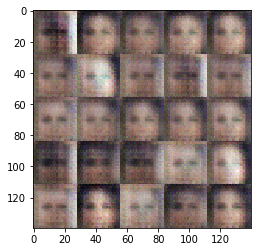

Epoch 1/1: batch 505/1582: 	time/batch: 0.44s	remaining time: 471s 	d_loss: 0.6064	g_loss: 1.2202
Epoch 1/1: batch 510/1582: 	time/batch: 0.44s	remaining time: 468s 	d_loss: 2.2530	g_loss: 0.1693
Epoch 1/1: batch 515/1582: 	time/batch: 0.44s	remaining time: 466s 	d_loss: 0.4788	g_loss: 4.2081
Epoch 1/1: batch 520/1582: 	time/batch: 0.44s	remaining time: 464s 	d_loss: 0.4302	g_loss: 2.1571
Epoch 1/1: batch 525/1582: 	time/batch: 0.44s	remaining time: 462s 	d_loss: 0.2144	g_loss: 2.4449
Epoch 1/1: batch 530/1582: 	time/batch: 0.44s	remaining time: 459s 	d_loss: 2.1405	g_loss: 0.1471
Epoch 1/1: batch 535/1582: 	time/batch: 0.44s	remaining time: 457s 	d_loss: 0.2847	g_loss: 3.4011
Epoch 1/1: batch 540/1582: 	time/batch: 0.44s	remaining time: 455s 	d_loss: 0.8882	g_loss: 0.7368
Epoch 1/1: batch 545/1582: 	time/batch: 0.44s	remaining time: 453s 	d_loss: 0.1616	g_loss: 6.3143
Epoch 1/1: batch 550/1582: 	time/batch: 0.44s	remaining time: 450s 	d_loss: 0.3257	g_loss: 1.6053
Epoch 1/1: batch 555

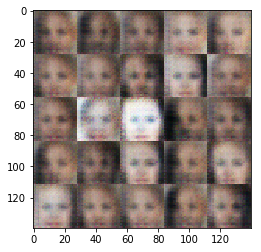

Epoch 1/1: batch 605/1582: 	time/batch: 0.44s	remaining time: 426s 	d_loss: 0.2903	g_loss: 1.9656
Epoch 1/1: batch 610/1582: 	time/batch: 0.44s	remaining time: 424s 	d_loss: 0.2435	g_loss: 2.0795
Epoch 1/1: batch 615/1582: 	time/batch: 0.44s	remaining time: 422s 	d_loss: 0.3930	g_loss: 6.2839
Epoch 1/1: batch 620/1582: 	time/batch: 0.44s	remaining time: 420s 	d_loss: 0.1183	g_loss: 5.6621
Epoch 1/1: batch 625/1582: 	time/batch: 0.44s	remaining time: 417s 	d_loss: 0.0989	g_loss: 9.2009
Epoch 1/1: batch 630/1582: 	time/batch: 0.44s	remaining time: 415s 	d_loss: 0.4357	g_loss: 7.9437
Epoch 1/1: batch 635/1582: 	time/batch: 0.44s	remaining time: 413s 	d_loss: 0.0761	g_loss: 4.8173
Epoch 1/1: batch 640/1582: 	time/batch: 0.44s	remaining time: 411s 	d_loss: 0.7810	g_loss: 0.8430
Epoch 1/1: batch 645/1582: 	time/batch: 0.44s	remaining time: 408s 	d_loss: 0.0490	g_loss: 5.3604
Epoch 1/1: batch 650/1582: 	time/batch: 0.44s	remaining time: 406s 	d_loss: 1.9351	g_loss: 0.1949
Epoch 1/1: batch 655

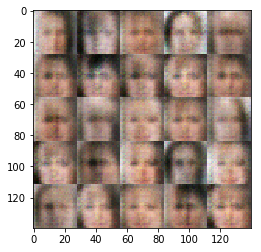

Epoch 1/1: batch 705/1582: 	time/batch: 0.44s	remaining time: 382s 	d_loss: 0.4600	g_loss: 9.8382
Epoch 1/1: batch 710/1582: 	time/batch: 0.44s	remaining time: 380s 	d_loss: 0.3723	g_loss: 1.4588
Epoch 1/1: batch 715/1582: 	time/batch: 0.44s	remaining time: 378s 	d_loss: 0.0898	g_loss: 3.3870
Epoch 1/1: batch 720/1582: 	time/batch: 0.44s	remaining time: 375s 	d_loss: 0.2239	g_loss: 2.8909
Epoch 1/1: batch 725/1582: 	time/batch: 0.44s	remaining time: 373s 	d_loss: 0.2123	g_loss: 2.0669
Epoch 1/1: batch 730/1582: 	time/batch: 0.44s	remaining time: 371s 	d_loss: 0.9672	g_loss: 0.5863
Epoch 1/1: batch 735/1582: 	time/batch: 0.44s	remaining time: 369s 	d_loss: 0.1606	g_loss: 3.5621
Epoch 1/1: batch 740/1582: 	time/batch: 0.44s	remaining time: 366s 	d_loss: 0.0588	g_loss: 5.5707
Epoch 1/1: batch 745/1582: 	time/batch: 0.44s	remaining time: 364s 	d_loss: 0.1643	g_loss: 3.5295
Epoch 1/1: batch 750/1582: 	time/batch: 0.44s	remaining time: 362s 	d_loss: 0.4938	g_loss: 9.0803
Epoch 1/1: batch 755

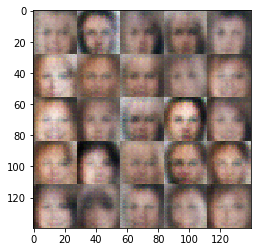

Epoch 1/1: batch 805/1582: 	time/batch: 0.44s	remaining time: 338s 	d_loss: 0.1804	g_loss: 10.1979
Epoch 1/1: batch 810/1582: 	time/batch: 0.44s	remaining time: 336s 	d_loss: 0.1793	g_loss: 2.7869
Epoch 1/1: batch 815/1582: 	time/batch: 0.44s	remaining time: 334s 	d_loss: 0.1704	g_loss: 3.0823
Epoch 1/1: batch 820/1582: 	time/batch: 0.44s	remaining time: 331s 	d_loss: 0.2567	g_loss: 2.7028
Epoch 1/1: batch 825/1582: 	time/batch: 0.44s	remaining time: 329s 	d_loss: 0.7454	g_loss: 0.8069
Epoch 1/1: batch 830/1582: 	time/batch: 0.44s	remaining time: 327s 	d_loss: 1.0986	g_loss: 0.4966
Epoch 1/1: batch 835/1582: 	time/batch: 0.44s	remaining time: 325s 	d_loss: 0.2580	g_loss: 7.3389
Epoch 1/1: batch 840/1582: 	time/batch: 0.44s	remaining time: 322s 	d_loss: 0.4894	g_loss: 7.7162
Epoch 1/1: batch 845/1582: 	time/batch: 0.44s	remaining time: 320s 	d_loss: 0.6735	g_loss: 1.0105
Epoch 1/1: batch 850/1582: 	time/batch: 0.44s	remaining time: 318s 	d_loss: 0.1531	g_loss: 2.8014
Epoch 1/1: batch 85

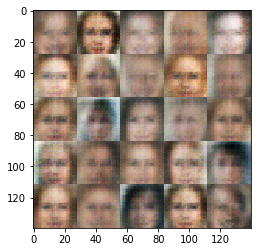

Epoch 1/1: batch 905/1582: 	time/batch: 0.44s	remaining time: 294s 	d_loss: 0.0894	g_loss: 4.9420
Epoch 1/1: batch 910/1582: 	time/batch: 0.44s	remaining time: 292s 	d_loss: 0.0659	g_loss: 3.6308
Epoch 1/1: batch 915/1582: 	time/batch: 0.44s	remaining time: 290s 	d_loss: 0.0490	g_loss: 7.4209
Epoch 1/1: batch 920/1582: 	time/batch: 0.44s	remaining time: 288s 	d_loss: 0.2672	g_loss: 1.9659
Epoch 1/1: batch 925/1582: 	time/batch: 0.44s	remaining time: 285s 	d_loss: 0.1081	g_loss: 3.0245
Epoch 1/1: batch 930/1582: 	time/batch: 0.44s	remaining time: 283s 	d_loss: 0.2274	g_loss: 2.5570
Epoch 1/1: batch 935/1582: 	time/batch: 0.44s	remaining time: 281s 	d_loss: 0.0460	g_loss: 7.2984
Epoch 1/1: batch 940/1582: 	time/batch: 0.44s	remaining time: 279s 	d_loss: 0.0405	g_loss: 9.3387
Epoch 1/1: batch 945/1582: 	time/batch: 0.44s	remaining time: 277s 	d_loss: 0.0611	g_loss: 3.3801
Epoch 1/1: batch 950/1582: 	time/batch: 0.43s	remaining time: 274s 	d_loss: 0.7005	g_loss: 0.8489
Epoch 1/1: batch 955

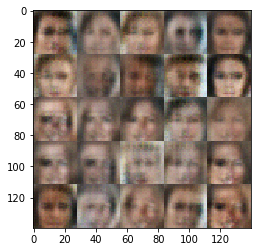

Epoch 1/1: batch 1005/1582: 	time/batch: 0.44s	remaining time: 251s 	d_loss: 0.0665	g_loss: 3.4761
Epoch 1/1: batch 1010/1582: 	time/batch: 0.44s	remaining time: 249s 	d_loss: 0.0987	g_loss: 6.4899
Epoch 1/1: batch 1015/1582: 	time/batch: 0.44s	remaining time: 246s 	d_loss: 0.0145	g_loss: 7.0714
Epoch 1/1: batch 1020/1582: 	time/batch: 0.44s	remaining time: 244s 	d_loss: 0.0240	g_loss: 5.7270
Epoch 1/1: batch 1025/1582: 	time/batch: 0.44s	remaining time: 242s 	d_loss: 0.1990	g_loss: 2.2433
Epoch 1/1: batch 1030/1582: 	time/batch: 0.44s	remaining time: 240s 	d_loss: 0.1255	g_loss: 5.3231
Epoch 1/1: batch 1035/1582: 	time/batch: 0.44s	remaining time: 238s 	d_loss: 0.5900	g_loss: 1.0018
Epoch 1/1: batch 1040/1582: 	time/batch: 0.44s	remaining time: 235s 	d_loss: 0.2293	g_loss: 9.8306
Epoch 1/1: batch 1045/1582: 	time/batch: 0.44s	remaining time: 233s 	d_loss: 0.0341	g_loss: 4.3316
Epoch 1/1: batch 1050/1582: 	time/batch: 0.44s	remaining time: 231s 	d_loss: 0.1007	g_loss: 3.8957
Epoch 1/1:

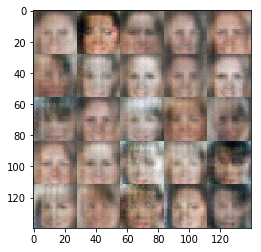

Epoch 1/1: batch 1105/1582: 	time/batch: 0.44s	remaining time: 207s 	d_loss: 0.0219	g_loss: 9.7319
Epoch 1/1: batch 1110/1582: 	time/batch: 0.44s	remaining time: 205s 	d_loss: 0.0401	g_loss: 8.0510
Epoch 1/1: batch 1115/1582: 	time/batch: 0.44s	remaining time: 203s 	d_loss: 0.0398	g_loss: 12.5396
Epoch 1/1: batch 1120/1582: 	time/batch: 0.44s	remaining time: 201s 	d_loss: 0.0134	g_loss: 6.2308
Epoch 1/1: batch 1125/1582: 	time/batch: 0.44s	remaining time: 198s 	d_loss: 0.0632	g_loss: 10.9835
Epoch 1/1: batch 1130/1582: 	time/batch: 0.44s	remaining time: 196s 	d_loss: 0.0354	g_loss: 5.3180
Epoch 1/1: batch 1135/1582: 	time/batch: 0.43s	remaining time: 194s 	d_loss: 0.0142	g_loss: 12.2337
Epoch 1/1: batch 1140/1582: 	time/batch: 0.43s	remaining time: 192s 	d_loss: 0.0084	g_loss: 7.5791
Epoch 1/1: batch 1145/1582: 	time/batch: 0.43s	remaining time: 190s 	d_loss: 0.2107	g_loss: 2.2557
Epoch 1/1: batch 1150/1582: 	time/batch: 0.43s	remaining time: 187s 	d_loss: 0.0136	g_loss: 8.6485
Epoch 1

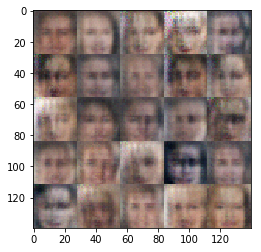

Epoch 1/1: batch 1205/1582: 	time/batch: 0.43s	remaining time: 163s 	d_loss: 0.0141	g_loss: 9.5299
Epoch 1/1: batch 1210/1582: 	time/batch: 0.43s	remaining time: 161s 	d_loss: 0.0268	g_loss: 4.9772
Epoch 1/1: batch 1215/1582: 	time/batch: 0.43s	remaining time: 159s 	d_loss: 0.0102	g_loss: 9.3194
Epoch 1/1: batch 1220/1582: 	time/batch: 0.43s	remaining time: 157s 	d_loss: 0.0167	g_loss: 5.4607
Epoch 1/1: batch 1225/1582: 	time/batch: 0.43s	remaining time: 155s 	d_loss: 0.1187	g_loss: 8.0685
Epoch 1/1: batch 1230/1582: 	time/batch: 0.43s	remaining time: 153s 	d_loss: 0.0625	g_loss: 11.8499
Epoch 1/1: batch 1235/1582: 	time/batch: 0.43s	remaining time: 150s 	d_loss: 0.0163	g_loss: 7.2052
Epoch 1/1: batch 1240/1582: 	time/batch: 0.43s	remaining time: 148s 	d_loss: 0.0390	g_loss: 3.9145
Epoch 1/1: batch 1245/1582: 	time/batch: 0.43s	remaining time: 146s 	d_loss: 0.0337	g_loss: 9.4431
Epoch 1/1: batch 1250/1582: 	time/batch: 0.43s	remaining time: 144s 	d_loss: 0.0100	g_loss: 7.0783
Epoch 1/1

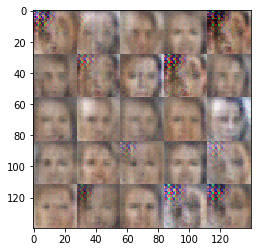

Epoch 1/1: batch 1305/1582: 	time/batch: 0.43s	remaining time: 120s 	d_loss: 0.2222	g_loss: 2.5433
Epoch 1/1: batch 1310/1582: 	time/batch: 0.43s	remaining time: 118s 	d_loss: 0.0216	g_loss: 6.9013
Epoch 1/1: batch 1315/1582: 	time/batch: 0.43s	remaining time: 116s 	d_loss: 0.0632	g_loss: 4.9816
Epoch 1/1: batch 1320/1582: 	time/batch: 0.43s	remaining time: 113s 	d_loss: 0.1071	g_loss: 2.8775
Epoch 1/1: batch 1325/1582: 	time/batch: 0.43s	remaining time: 111s 	d_loss: 0.0153	g_loss: 8.1351
Epoch 1/1: batch 1330/1582: 	time/batch: 0.43s	remaining time: 109s 	d_loss: 0.0856	g_loss: 3.0485
Epoch 1/1: batch 1335/1582: 	time/batch: 0.43s	remaining time: 107s 	d_loss: 0.2696	g_loss: 9.5636
Epoch 1/1: batch 1340/1582: 	time/batch: 0.43s	remaining time: 105s 	d_loss: 0.0127	g_loss: 7.1552
Epoch 1/1: batch 1345/1582: 	time/batch: 0.43s	remaining time: 103s 	d_loss: 0.0422	g_loss: 6.6759
Epoch 1/1: batch 1350/1582: 	time/batch: 0.43s	remaining time: 100s 	d_loss: 0.0437	g_loss: 7.5023
Epoch 1/1:

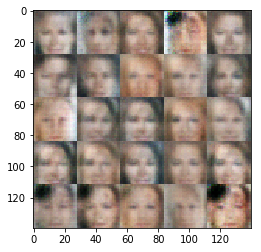

Epoch 1/1: batch 1405/1582: 	time/batch: 0.43s	remaining time: 76s 	d_loss: 0.0199	g_loss: 8.4500
Epoch 1/1: batch 1410/1582: 	time/batch: 0.43s	remaining time: 74s 	d_loss: 0.0409	g_loss: 5.9676
Epoch 1/1: batch 1415/1582: 	time/batch: 0.43s	remaining time: 72s 	d_loss: 0.0312	g_loss: 5.7047
Epoch 1/1: batch 1420/1582: 	time/batch: 0.43s	remaining time: 70s 	d_loss: 0.1684	g_loss: 2.3315
Epoch 1/1: batch 1425/1582: 	time/batch: 0.43s	remaining time: 68s 	d_loss: 0.4023	g_loss: 8.2862
Epoch 1/1: batch 1430/1582: 	time/batch: 0.43s	remaining time: 66s 	d_loss: 0.1218	g_loss: 3.9997
Epoch 1/1: batch 1435/1582: 	time/batch: 0.43s	remaining time: 63s 	d_loss: 0.3519	g_loss: 1.8700
Epoch 1/1: batch 1440/1582: 	time/batch: 0.43s	remaining time: 61s 	d_loss: 0.1139	g_loss: 2.8792
Epoch 1/1: batch 1445/1582: 	time/batch: 0.43s	remaining time: 59s 	d_loss: 0.0489	g_loss: 10.8608
Epoch 1/1: batch 1450/1582: 	time/batch: 0.43s	remaining time: 57s 	d_loss: 0.0361	g_loss: 13.0766
Epoch 1/1: batch 1

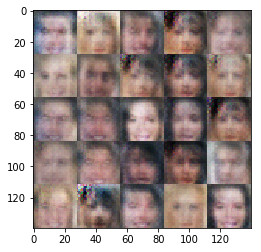

Epoch 1/1: batch 1505/1582: 	time/batch: 0.43s	remaining time: 33s 	d_loss: 0.9971	g_loss: 0.5500
Epoch 1/1: batch 1510/1582: 	time/batch: 0.43s	remaining time: 31s 	d_loss: 0.0167	g_loss: 9.5667
Epoch 1/1: batch 1515/1582: 	time/batch: 0.43s	remaining time: 29s 	d_loss: 0.6677	g_loss: 0.9370
Epoch 1/1: batch 1520/1582: 	time/batch: 0.43s	remaining time: 26s 	d_loss: 0.0123	g_loss: 5.4927
Epoch 1/1: batch 1525/1582: 	time/batch: 0.43s	remaining time: 24s 	d_loss: 0.0482	g_loss: 9.5603
Epoch 1/1: batch 1530/1582: 	time/batch: 0.43s	remaining time: 22s 	d_loss: 0.0272	g_loss: 7.8110
Epoch 1/1: batch 1535/1582: 	time/batch: 0.43s	remaining time: 20s 	d_loss: 0.3464	g_loss: 1.5249
Epoch 1/1: batch 1540/1582: 	time/batch: 0.43s	remaining time: 18s 	d_loss: 0.0454	g_loss: 7.4770
Epoch 1/1: batch 1545/1582: 	time/batch: 0.43s	remaining time: 16s 	d_loss: 0.0249	g_loss: 8.9504
Epoch 1/1: batch 1550/1582: 	time/batch: 0.43s	remaining time: 13s 	d_loss: 0.0808	g_loss: 3.3188
Epoch 1/1: batch 155

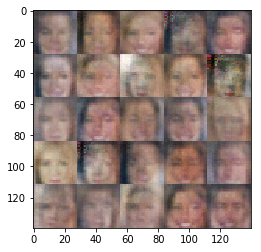

In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

d_losses = []
g_losses = []


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    # jcc: added lists for plotting discriminator and generator losses
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

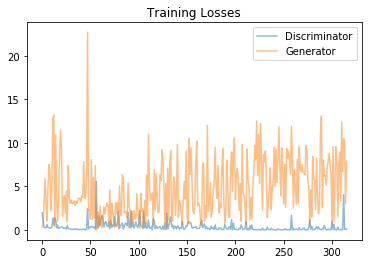

In [17]:
plot_losses(d_losses, g_losses)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.